In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer, weighted_quantile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import os
import seaborn as sns

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [4]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


## Reference trajectory

In [16]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 20)

In [17]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)

In [27]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1500, 0, 10],
             [0, 300, 2],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1, keepdims=True)
print (np.sum(R_norm, axis =1))
print(tmat.value)

[1. 1. 1.]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [28]:
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)

(250, 3, 5)


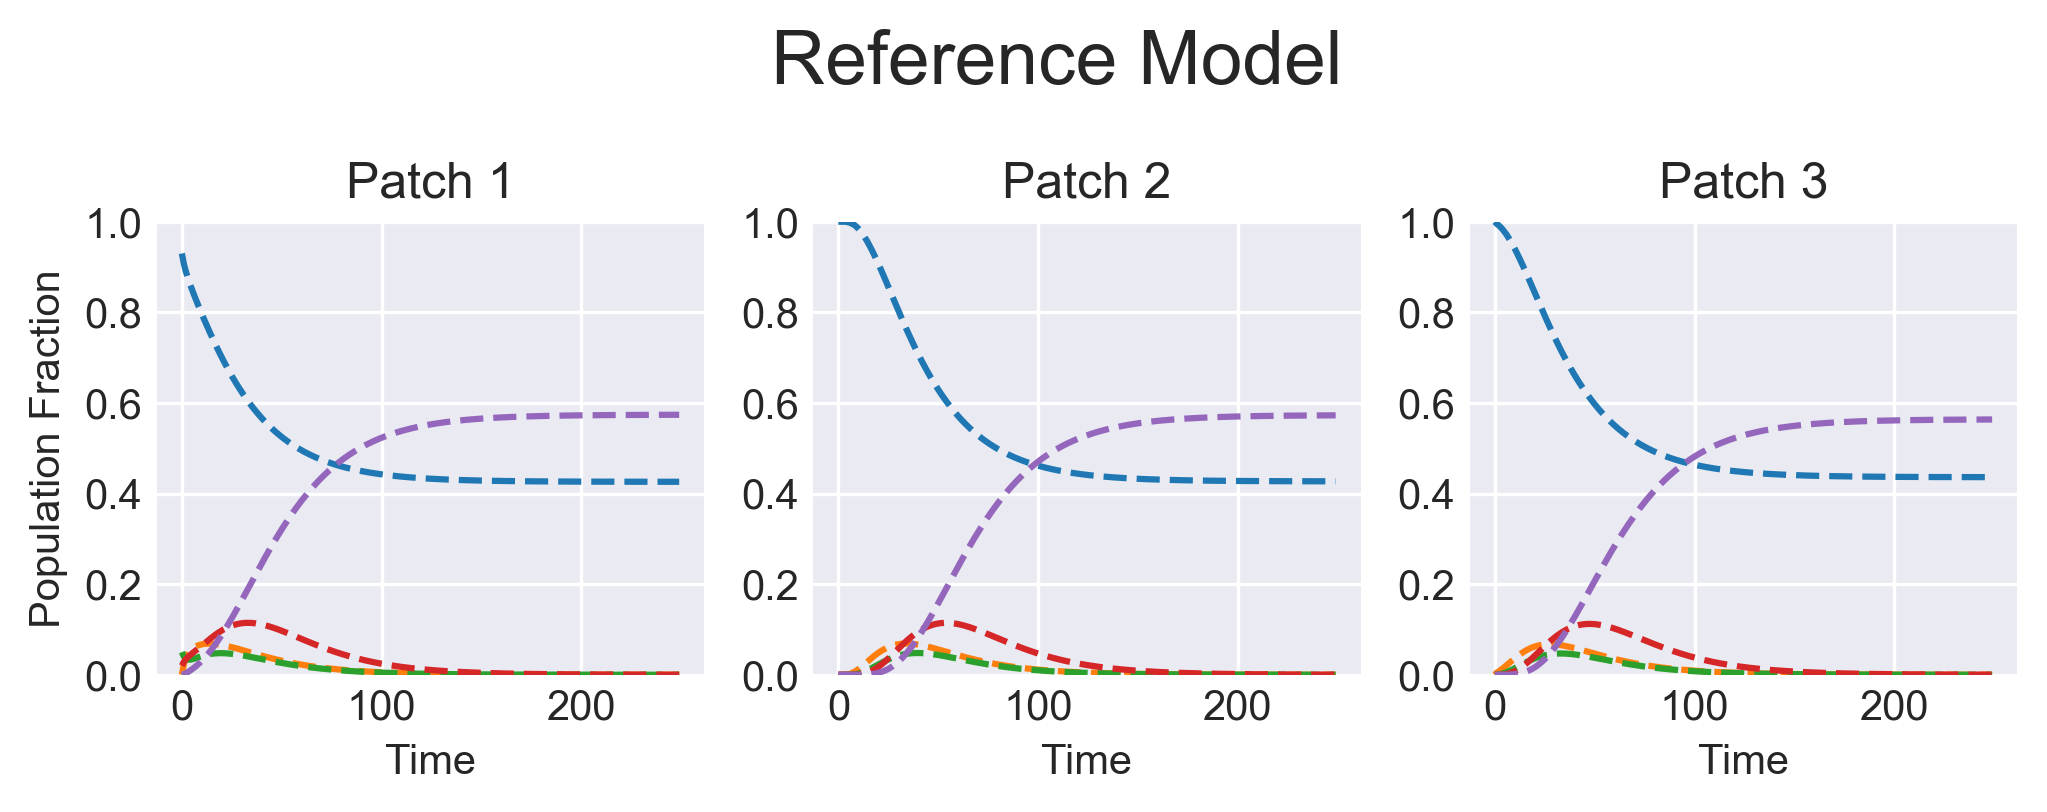

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
# print (ref_traj[:-20:,0,:])
# print (ref_traj[:-20:,1,:])
# print (ref_traj[:-20:,1,:] == ref_traj[:-20:,0,:])
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))

In [10]:
# def f(beta, ntot, ninf):
#     p = 1 - tf.math.exp(tf.math.log(1 - tf.reshape(beta, (-1, 1)))
#                           * tf.reduce_sum((ninf) / ntot[:, :, tf.newaxis], axis=2))
#     return p
# p = []
# for i in np.linspace(0,1,10):
#     ninf = np.zeros((1,M), dtype = np.float32)
#     ninf[0,0] = i
#     print (f(0.01, np.ones((1,M), dtype = np.float32),ninf))
#     p.append(f(0.01, np.ones((1,M), dtype = np.float32),ninf))


## Sample SEAIR Trajectories

Creating a set of trajectories.

In [534]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 2, 1)
tmat.add_transition('A', 'I', 2, 4)
tmat.add_transition('I', 'R', 10, 5)
full_compartments = ['S'] + compartments

In [463]:
# starting fractions probabilities
start_logits = np.zeros((M)) #anywhere
start_logits[0]=np.log(0.99)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.01
hyper_pram.beta_high = 0.15
hyper_pram.beta_low = 0.001
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.4
hyper_pram.start_var = 0.8
# hyper_pram.R_var = 0.9
# hyper_pram.start_high = 0.01
# R_sample_norm = np.array([[0.1, 0.8, 0.1],
#              [0.05, 0.8, 0.15],
#              [0.01, 0.12, 0.87]])
# # R_sample_norm = R_sample / np.sum(R_sample, axis=1)

In [464]:
param_model = maxentep.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)

In [472]:
# Fxing beta and mobility matrix
R_norm_sample = tf.convert_to_tensor(R_norm)
beta_sample = tf.convert_to_tensor([0.025])
import tqdm
#tf.debugging.enable_check_numerics()
N = 2048
batches = 4
batch_size = N*batches
outs = []
timesteps = 250
# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    psample[0] = tf.repeat(R_norm_sample[tf.newaxis,:], len(psample[0]), axis =0) 
    psample[3] = tf.repeat(beta_sample[tf.newaxis,:], len(psample[0]), axis =0)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

  0%|                                                                                                                                                  | 0/4 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.18s/it]

(8192, 250, 3, 5)


In [466]:
beta_sample = tf.constant([0.025])
# a = tf.repeat(beta_sample[tf.newaxis], len(psample[0]), axis =0)
print('start before: ',beta_sample)
# print('R_norm is :',R_norm)
# # tf.assign(psample[:][0], tf.convert_to_tensor(R_norm))
# R_norm_sample = tf.convert_to_tensor(R_norm)
# print (R_norm_sample)
# psample[0] = tf.repeat(R_norm_sample[tf.newaxis,:], len(psample[0]), axis =0)
# print('psample after ',psample[0])
# print(len(psample[0]))

start before:  tf.Tensor([0.025], shape=(1,), dtype=float32)


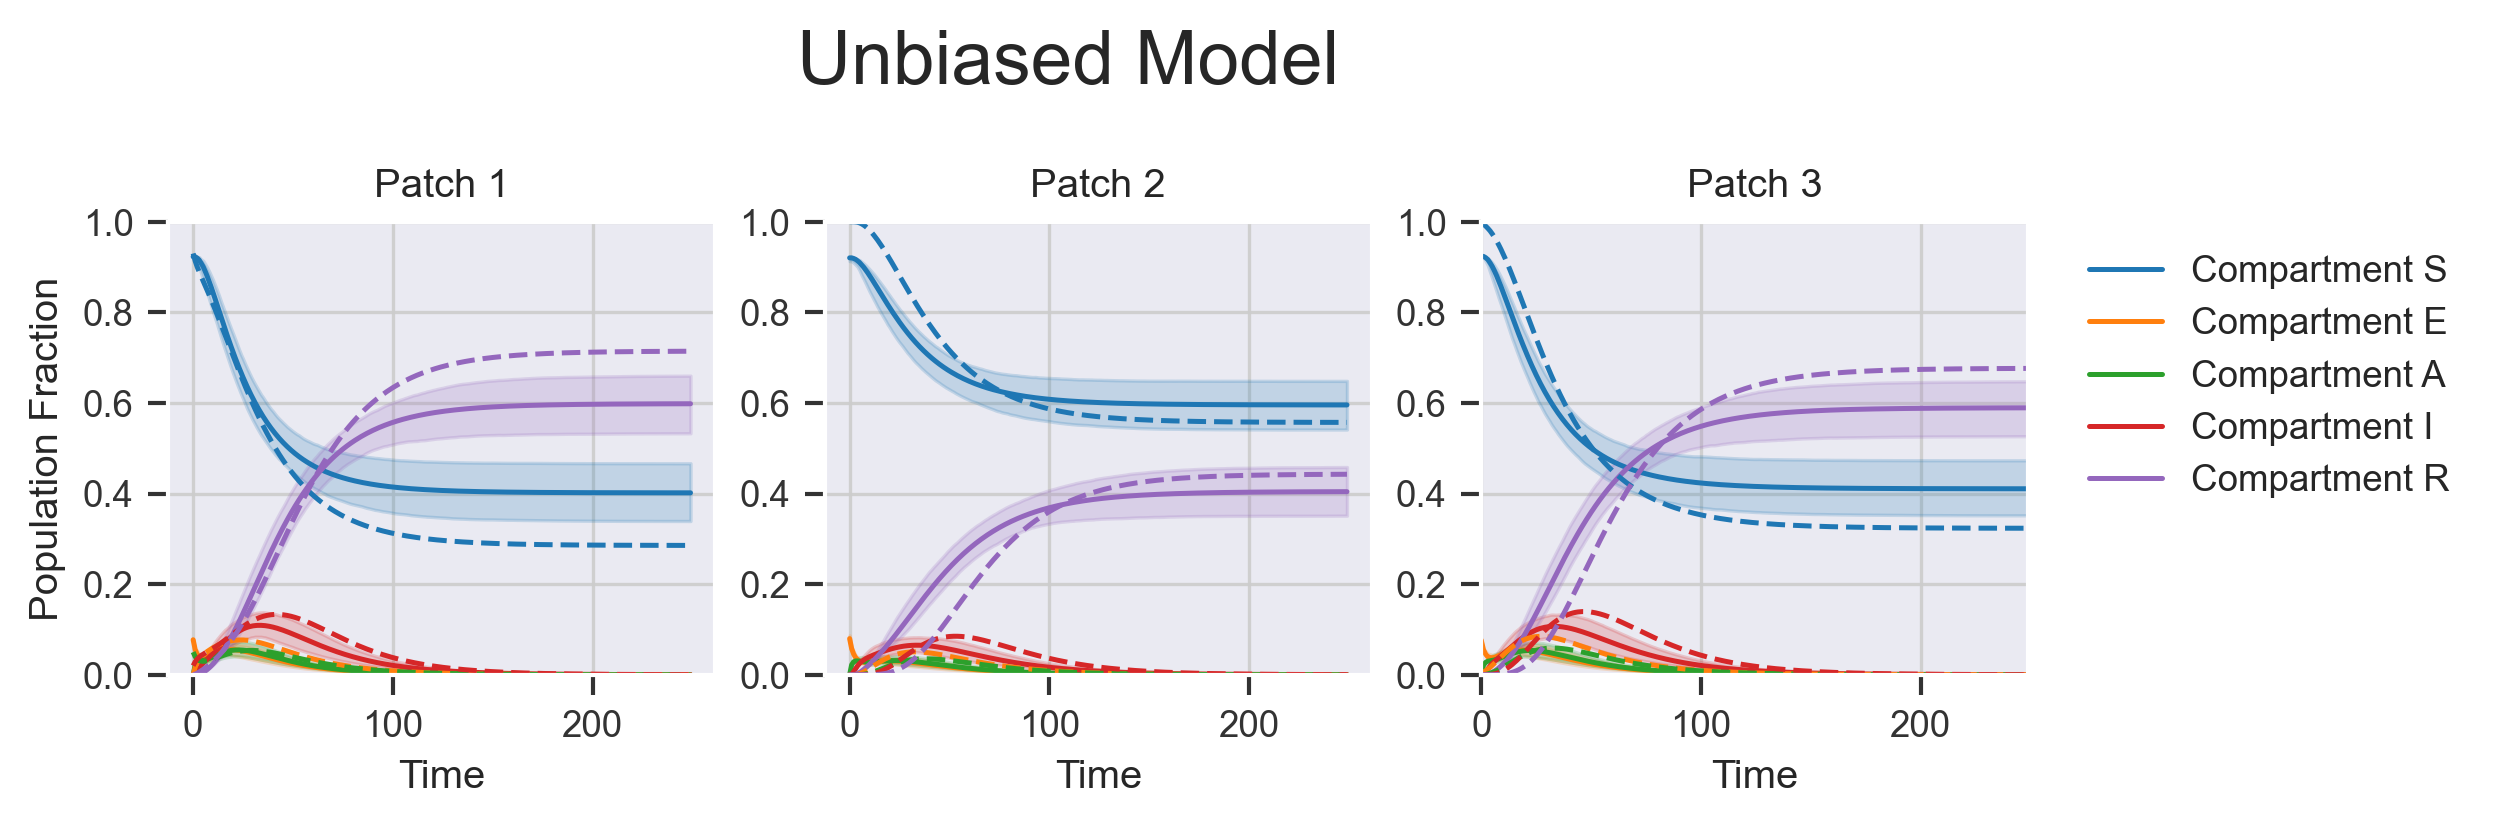

In [473]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

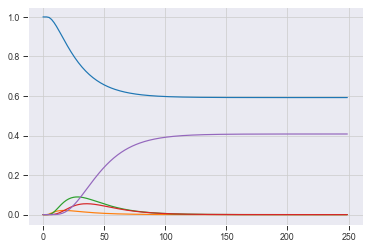

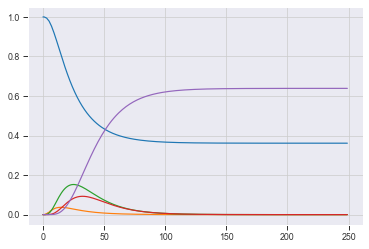

In [405]:
plt.plot(trajs[1234,:,1,:])
plt.show()
plt.plot(trajs[1234,:,2,:])
# print (trajs[:-20:,1,:] == trajs[:-20:,0,:])
# fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
# # fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
# axs[0].plot(trajs[0,:,0,:])
# axs[1].plot(trajs[100,:,1,:])
# # maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# for i in range (M):
#     plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
#     axs[i].plot(ref_traj[:,i],linestyle='--')
# axs[0].set_ylabel('Population Fraction')
# plt.show()

## Make restraints from reference trajectory

In [474]:
npoints = 5
np.random.seed(0)
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300838 0.10784743734654037
45 0.13207568 0.15260560737936643
31 0.121692084 0.12889426233404105
80 0.06942841 0.1421420820039372
17 0.08018887 0.11824075668734235


In [475]:
print (restraints_dict)
print (ref_traj[59,0,3])
print (ref_traj[59,0,3] - restraints[0].target)

{'npoints': 5, 'restrained_patches': [0], 'restrained_compartments': [3]}
tf.Tensor(0.11310515, shape=(), dtype=float32)
tf.Tensor(0.005257711, shape=(), dtype=float32)


## Visualizing Restraints

Text(0, 0.5, 'Population Fraction')

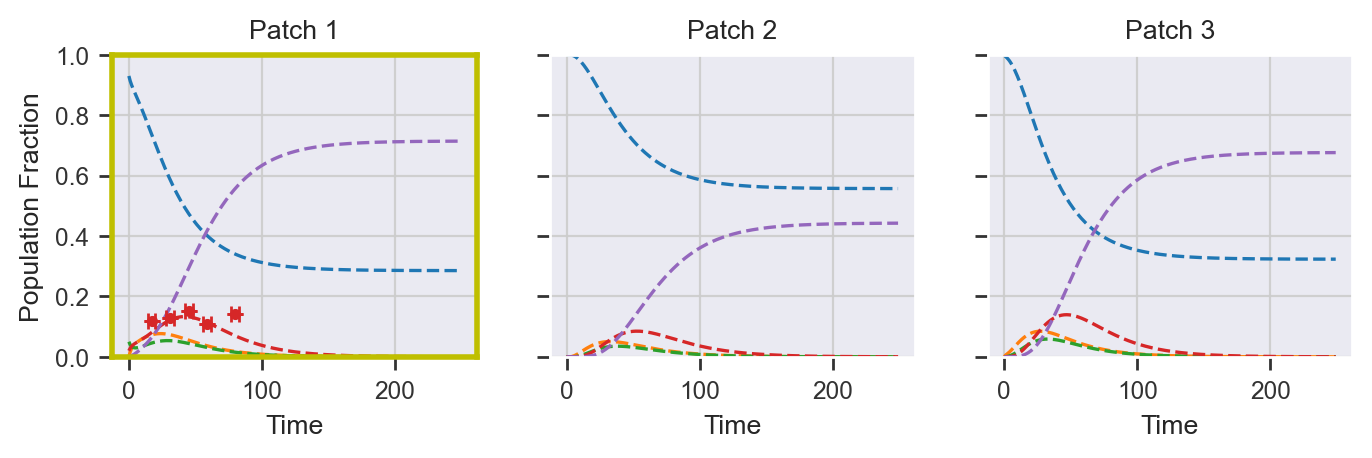

In [476]:
fig, axs = plt.subplots(nrows=1, ncols=M, sharex=True,
                           sharey=True, figsize=(8,2), dpi =200)
for i in range(M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1),ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')


In [477]:
me_model = maxentep.MaxentModel(restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000, callbacks=[CustomCallback()])

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - ref-error-metric: 0.2052 - ref-error: 0.2052 - weight-entropy: 9.0085
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0035 - ref-error-metric: 0.2054 - ref-error: 0.2054 - weight-entropy: 9.0086
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0035 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 9.0087
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - ref-error-metric: 0.2050 - ref-error: 0.2050 - weight-entropy: 9.0088
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0035 - ref-error-metric: 0.2052 - ref-error: 0.2052 - weight-entropy: 9.0089
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - ref-error-metric: 0.2051 - ref-error: 0.2051 - weight-entropy: 9.0090
Epoch 7/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0035 - ref-error-m

1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 0.2056 - ref-error: 0.2056 - weight-entropy: 8.9915
Epoch 108/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0026 - ref-error-metric: 0.2071 - ref-error: 0.2071 - weight-entropy: 8.9911
Epoch 109/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 0.2046 - ref-error: 0.2046 - weight-entropy: 8.9906
Epoch 110/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 0.2057 - ref-error: 0.2057 - weight-entropy: 8.9902
Epoch 111/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0026 - ref-error-metric: 0.2065 - ref-error: 0.2065 - weight-entropy: 8.9898
Epoch 112/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0026 - ref-error-metric: 0.2043 - ref-error: 0.2043 - weight-entropy: 8.9893
Epoch 113/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0025 - ref-error-

1/1 [==============================] - 0s 983us/step - loss: 0.0019 - ref-error-metric: 0.2028 - ref-error: 0.2028 - weight-entropy: 8.9246
Epoch 214/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 0.2070 - ref-error: 0.2070 - weight-entropy: 8.9238
Epoch 215/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 0.2093 - ref-error: 0.2093 - weight-entropy: 8.9230
Epoch 216/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 0.2063 - ref-error: 0.2063 - weight-entropy: 8.9222
Epoch 217/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 8.9214
Epoch 218/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 0.2054 - ref-error: 0.2054 - weight-entropy: 8.9206
Epoch 219/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-

1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2018 - ref-error: 0.2018 - weight-entropy: 8.8309
Epoch 320/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2073 - ref-error: 0.2073 - weight-entropy: 8.8300
Epoch 321/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0015 - ref-error-metric: 0.2098 - ref-error: 0.2098 - weight-entropy: 8.8290
Epoch 322/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2069 - ref-error: 0.2069 - weight-entropy: 8.8281
Epoch 323/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.1990 - ref-error: 0.1990 - weight-entropy: 8.8272
Epoch 324/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2055 - ref-error: 0.2055 - weight-entropy: 8.8263
Epoch 325/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-me

1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - ref-error-metric: 0.1946 - ref-error: 0.1946 - weight-entropy: 8.7374
Epoch 426/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - ref-error-metric: 0.2028 - ref-error: 0.2028 - weight-entropy: 8.7366
Epoch 427/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - ref-error-metric: 0.2012 - ref-error: 0.2012 - weight-entropy: 8.7358
Epoch 428/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 8.7350
Epoch 429/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - ref-error-metric: 0.2028 - ref-error: 0.2028 - weight-entropy: 8.7342
Epoch 430/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - ref-error-metric: 0.2078 - ref-error: 0.2078 - weight-entropy: 8.7334
Epoch 431/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0013 - ref-error-met

1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.6624
Epoch 532/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2012 - ref-error: 0.2012 - weight-entropy: 8.6618
Epoch 533/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2160 - ref-error: 0.2160 - weight-entropy: 8.6612
Epoch 534/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0012 - ref-error-metric: 0.2061 - ref-error: 0.2061 - weight-entropy: 8.6606
Epoch 535/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2048 - ref-error: 0.2048 - weight-entropy: 8.6600
Epoch 536/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2069 - ref-error: 0.2069 - weight-entropy: 8.6594
Epoch 537/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0012 - ref-error-

1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2045 - ref-error: 0.2045 - weight-entropy: 8.6106
Epoch 638/1000
1/1 [==============================] - 0s 988us/step - loss: 0.0012 - ref-error-metric: 0.2026 - ref-error: 0.2026 - weight-entropy: 8.6102
Epoch 639/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0012 - ref-error-metric: 0.2154 - ref-error: 0.2154 - weight-entropy: 8.6098
Epoch 640/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2016 - ref-error: 0.2016 - weight-entropy: 8.6094
Epoch 641/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2188 - ref-error: 0.2188 - weight-entropy: 8.6091
Epoch 642/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.1966 - ref-error: 0.1966 - weight-entropy: 8.6087
Epoch 643/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - ref-error-

1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2126 - ref-error: 0.2126 - weight-entropy: 8.5782
Epoch 744/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2028 - ref-error: 0.2028 - weight-entropy: 8.5779
Epoch 745/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2069 - ref-error: 0.2069 - weight-entropy: 8.5777
Epoch 746/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2131 - ref-error: 0.2131 - weight-entropy: 8.5775
Epoch 747/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0011 - ref-error-metric: 0.2078 - ref-error: 0.2078 - weight-entropy: 8.5772
Epoch 748/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0011 - ref-error-metric: 0.1991 - ref-error: 0.1991 - weight-entropy: 8.5770
Epoch 749/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-

1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2096 - ref-error: 0.2096 - weight-entropy: 8.5586
Epoch 850/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2040 - ref-error: 0.2040 - weight-entropy: 8.5585
Epoch 851/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.5584
Epoch 852/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2091 - ref-error: 0.2091 - weight-entropy: 8.5582
Epoch 853/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2025 - ref-error: 0.2025 - weight-entropy: 8.5581
Epoch 854/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2005 - ref-error: 0.2005 - weight-entropy: 8.5579
Epoch 855/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metr

1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-metric: 0.2099 - ref-error: 0.2099 - weight-entropy: 8.5467
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2097 - ref-error: 0.2097 - weight-entropy: 8.5466
Epoch 957/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2107 - ref-error: 0.2107 - weight-entropy: 8.5466
Epoch 958/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2258 - ref-error: 0.2258 - weight-entropy: 8.5465
Epoch 959/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2139 - ref-error: 0.2139 - weight-entropy: 8.5464
Epoch 960/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.1989 - ref-error: 0.1989 - weight-entropy: 8.5463
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-me

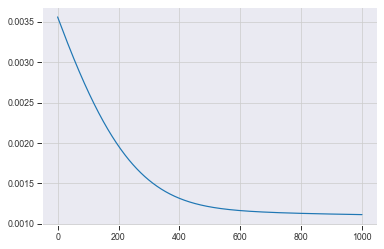

In [478]:
plt.plot(me_history.history['loss'])

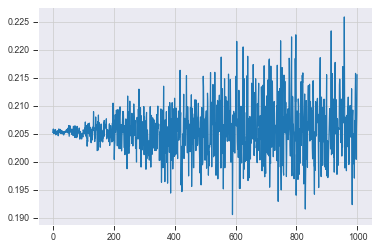

In [479]:
plt.plot(me_history.history['ref-error'])

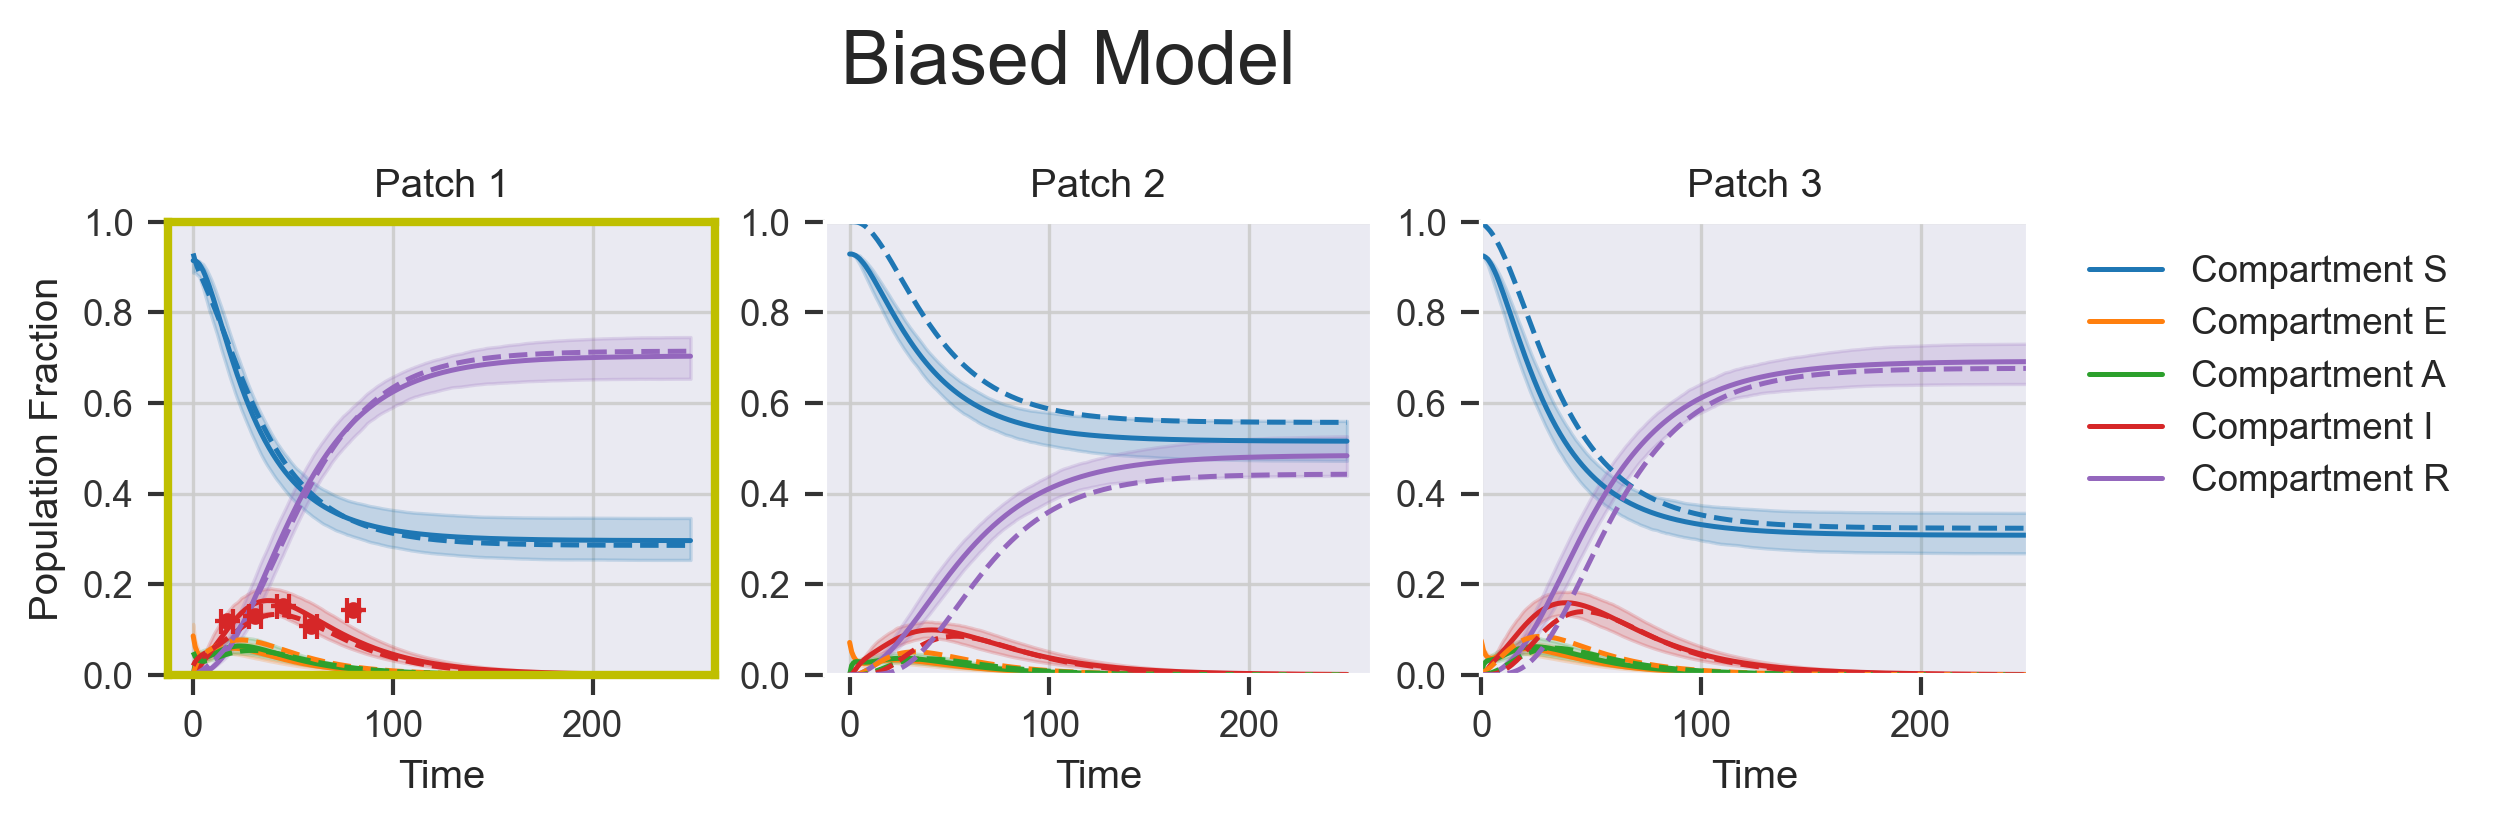

In [480]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(me_model.trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,1,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,2,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [535]:
Tmtat = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.001
start[0,1] = 0.001
# start[1,0] = 0.05
beta_start = 0.1
infect = maxentep.ContactInfectionLayer(beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, agreement)

In [536]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(timesteps)
regressed_traj = rmodel.get_traj()

250/250 [==============================] - 48s 190ms/step - loss: 0.0034 - output_2_loss: 0.0034


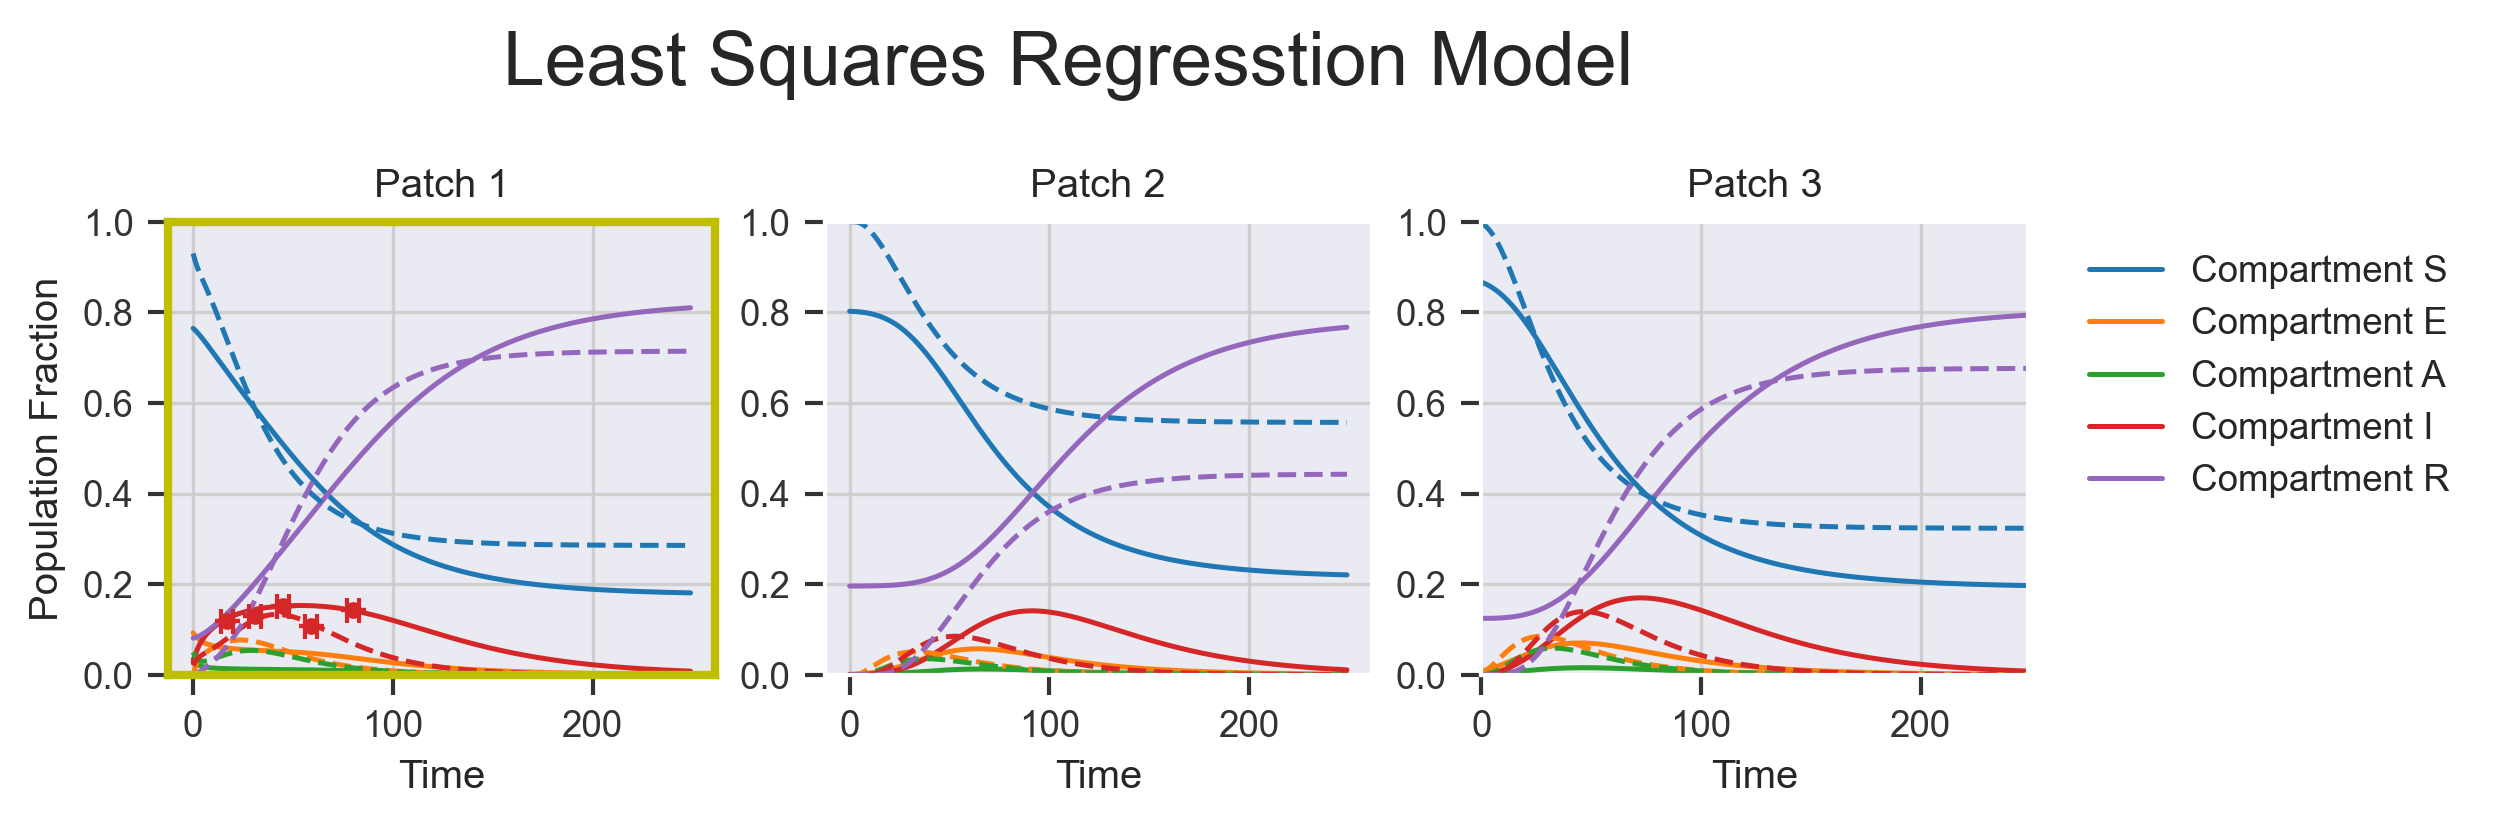

In [485]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regresstion Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
#     axs[i].plot(regressed_traj[0,:,i,:])
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Hyper-biasing

In [27]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R_norm , tmat, name='unbiased_model', hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(1))
# fit_param_model.compile(tf.optimizers.Adam(0.1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')

In [28]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)

Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 10/1000
128/128 [=====

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1543
Epoch 144/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1542
Epoch 145/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1542
Epoch 146/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1541
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1541
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1540
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1539
Epoch 150/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1539: 0s - loss: 0.0021 - weight-entropy: 
Epoch 151/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-ent

128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1434
Epoch 292/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1433
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1432
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1431
Epoch 295/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1431
Epoch 296/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1430
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1429
Epoch 298/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1429
Epoch 299/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1427
Epoch 300/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1306
Epoch 440/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1304
Epoch 441/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1304
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1303
Epoch 443/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1302
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1301
Epoch 445/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1300
Epoch 446/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1299
Epoch 447/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1298
Epoch 448/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1180
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1179
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1180
Epoch 590/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1180
Epoch 591/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1177
Epoch 592/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1176
Epoch 593/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1176
Epoch 594/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1174
Epoch 595/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1173
Epoch 596/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1072
Epoch 735/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1070
Epoch 736/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1067
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1071
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1070
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1072
Epoch 740/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1067
Epoch 741/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1066
Epoch 742/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1063
Epoch 743/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0976
Epoch 883/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0980
Epoch 884/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0975
Epoch 885/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0977
Epoch 886/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0977
Epoch 887/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0976
Epoch 888/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0976
Epoch 889/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0975
Epoch 890/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0974
Epoch 891/1000
128/128 [=

In [29]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)

Epoch 1/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1446
Epoch 2/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1016
Epoch 3/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0813
Epoch 4/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0790
Epoch 5/200
128/128 [==============================] - ETA: 0s - loss: 0.0017 - weight-entropy: 4.07 - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.0768
Epoch 6/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.0756
Epoch 7/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.0763
Epoch 8/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 4.0721
Epoch 9/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entro

128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.4880
Epoch 146/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4793
Epoch 147/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4794
Epoch 148/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4808
Epoch 149/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.4821
Epoch 150/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4737
Epoch 151/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4787
Epoch 152/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4776
Epoch 153/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4798
Epoch 154/200
128/128 [==========

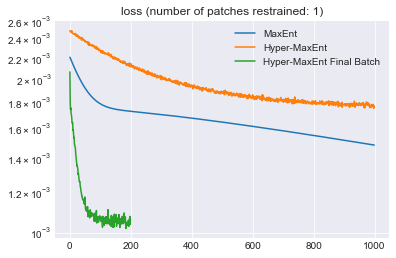

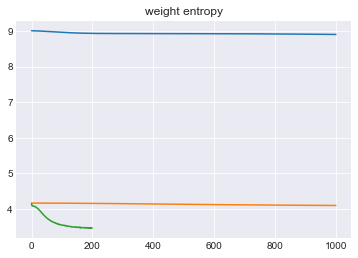

In [30]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
# plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(hme_history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

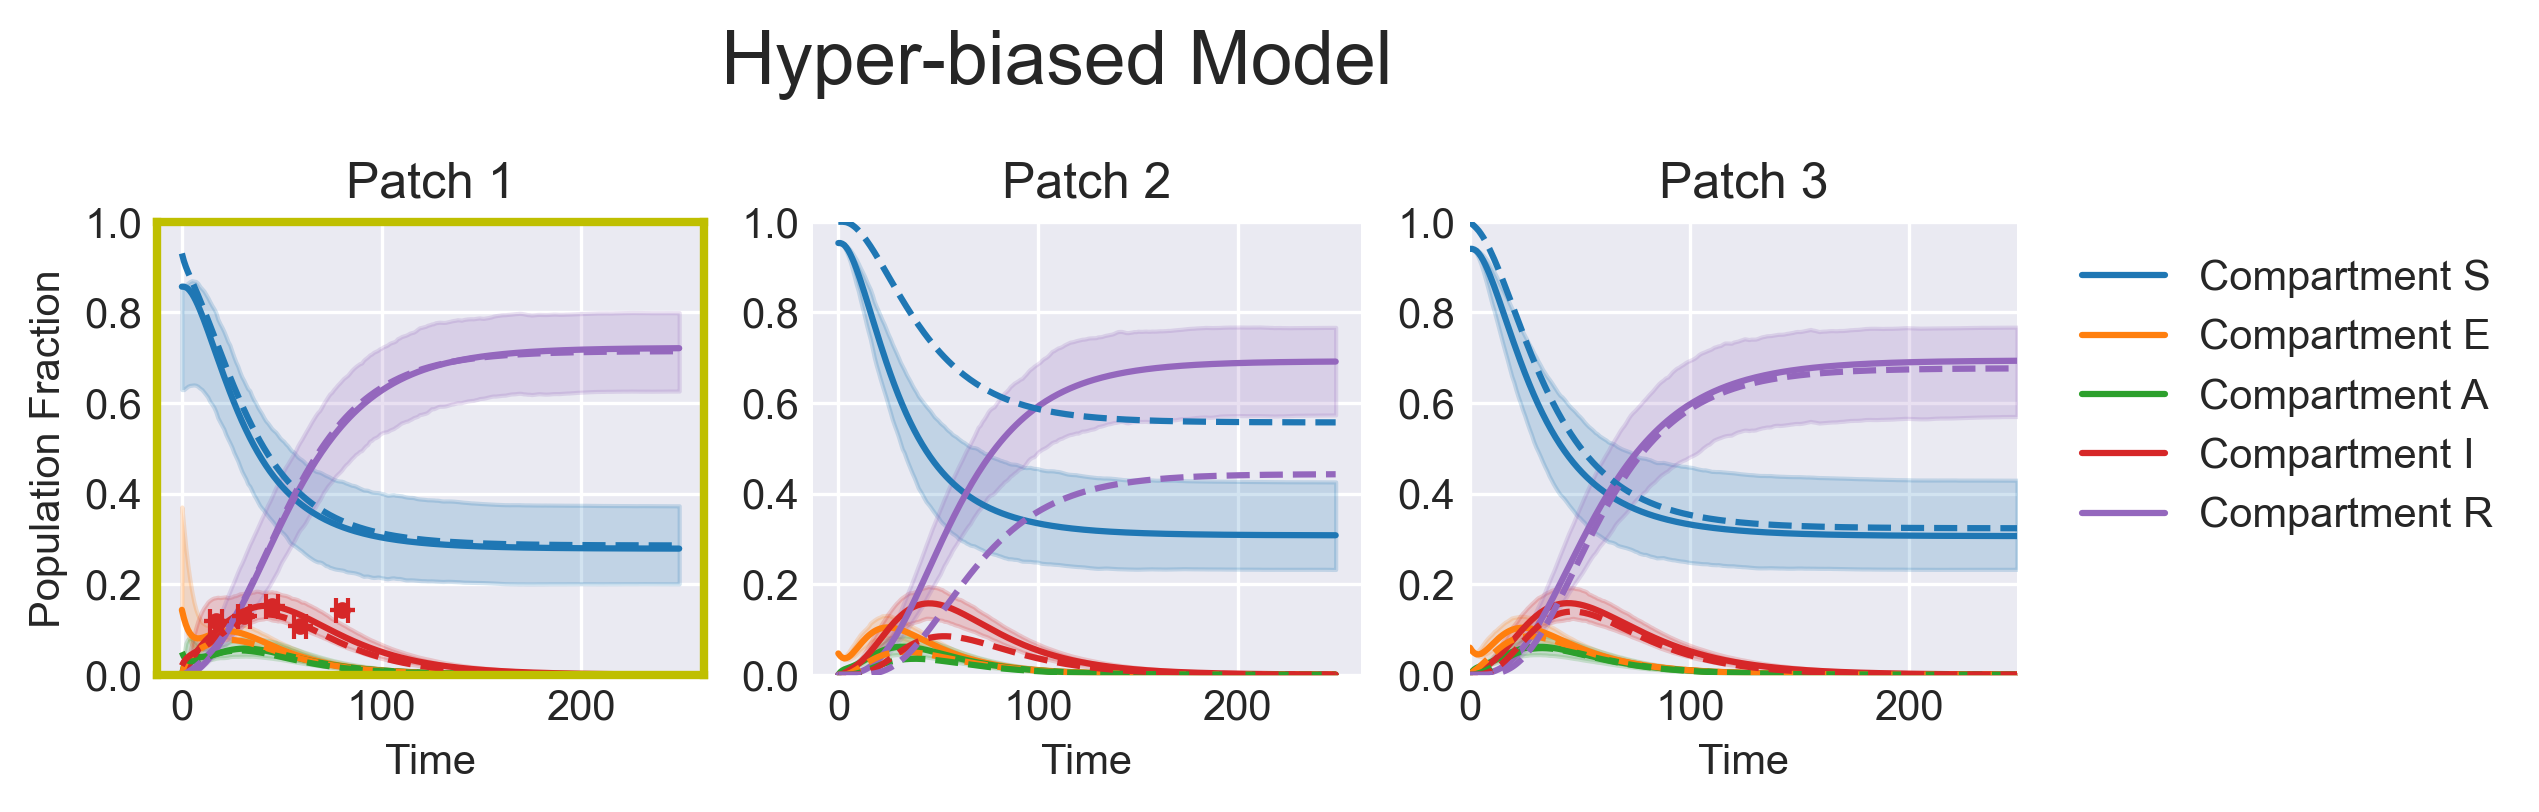

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Hyper-biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## ABC

In [34]:
# import pyabc
# import os
# beta = 0.025
# E_time = 7
# A_time = 5
# I_time = 14
# def sbi_model(parameters):
#     start, beta, E_time, A_time, I_time = parameters['start'], \
#                                                    + float(parameters['beta']), float(parameters['E_time']), \
#                                                    + float(parameters['A_time']), float(parameters['I_time'])
#     compartments = ['E', 'A', 'I', 'R']
#     infections_compartments = [1,2]
#     tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
#     tmat.add_transition('E', 'A', E_time, 3)
#     tmat.add_transition('A', 'I', A_time, 3)
#     tmat.add_transition('I', 'R', I_time, 4)
#     infect_fxn_sbi = maxentep.contact_infection_func(infections_compartments)
#     timesteps = 250
#     meta_model = maxentep.MetaModel(infect_fxn_sbi, timesteps, populations=population_fraction)
#     trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
#     restrainted_time_values = [59, 45, 31, 80, 17]
#     values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
#     return {'data': values}
# sbi_param_keys = [ 'start', 'beta', 'E_time', 'A_time', 'I_time' ]
# sbi_param_values = [start, beta, E_time, A_time, I_time ] 
# sbi_parameters = dict(zip(sbi_param_keys, sbi_param_values))
# sbi_result = sbi_model(sbi_parameters)


# def distance(x, y):
#     print ('current calue', x['data'])
#     print ('goal', y['data'])
#     d = np.sum(np.abs(x['data'] - y['data']))
#     print (f'distance{d}')
#     return(d)

# # 59 0.11300838 0.10784743734654037
# # 45 0.13207568 0.15260560737936643
# # 31 0.121692084 0.12889426233404105
# # 80 0.06942841 0.1421420820039372
# # 17 0.08018887 0.11824075668734235
# print (sbi_result)

# # R_norm, start, beta, E_time, A_time, I_time 
# parameter_priors = pyabc.Distribution(# R_norm=pyabc.RV("norm", sbi_param_values[0], 1), 
#                                 start=pyabc.RV("norm", sbi_param_values[0], 0.01),
#                                 beta=pyabc.RV("norm", sbi_param_values[1], 0.1),
#                                 E_time=pyabc.RV("norm", sbi_param_values[2], 1),
#                                 A_time=pyabc.RV("norm", sbi_param_values[3], 1),
#                                 I_time=pyabc.RV("norm", sbi_param_values[4], 1))

# print(parameter_priors )



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



{'data': array([0.12532003, 0.14010824, 0.11538681, 0.07863417, 0.05513906],
      dtype=float32)}
<Distribution 'A_time', 'E_time', 'I_time', 'beta', 'start'>


In [38]:
# abc = pyabc.ABCSMC(sbi_model, parameter_priors, distance)
# db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_gravitation.db') 
# observation = np.array([r.target for r in restraints])
# abc.new(db_path, {'data': observation})
# # x_1 = np.array([0.009231301, 0.028030522, 0.08351496, 0.0017322148, 0.22831888])
# # x_2 = np.array([0.10784743734654037, 0.15260560737936643, 0.12889426233404105, 0.1421420820039372, 0.11824075668734235])
# # print(distance(x_1,x_2))
# print (observation)

KeyboardInterrupt: 

In [37]:
# import logging
# tf.get_logger().setLevel(logging.ERROR)
# history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:Epsilon:initial epsilon is 0.5832638263910389
INFO:ABC:t: 1, eps: 0.5832638263910389.


current calue [0.00052758 0.00133865 0.00338009 0.00013044 0.00810375]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6362496366874163
current calue [0.00050768 0.00146227 0.00403363 0.00010156 0.00952717]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6340978408571297
current calue [0.13757348 0.2084921  0.22690307 0.05655853 0.11624991]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.2711957325252106
current calue [1.9362046e-04 5.8679900e-04 1.7710148e-03 3.6680474e-05 5.0493437e-03]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.642092687363465
current calue [0.13032937 0.25416207 0.34148774 0.03641859 0.18586804]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.509982650158388
current calue [0.09943781 0.22391567 0.40117368 0.02643587 0.3281317 ]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6775962646769559
current calue [0.000715   0

IndexError: index 0 is out of bounds for axis 0 with size 0

(3, 250, 3, 5)


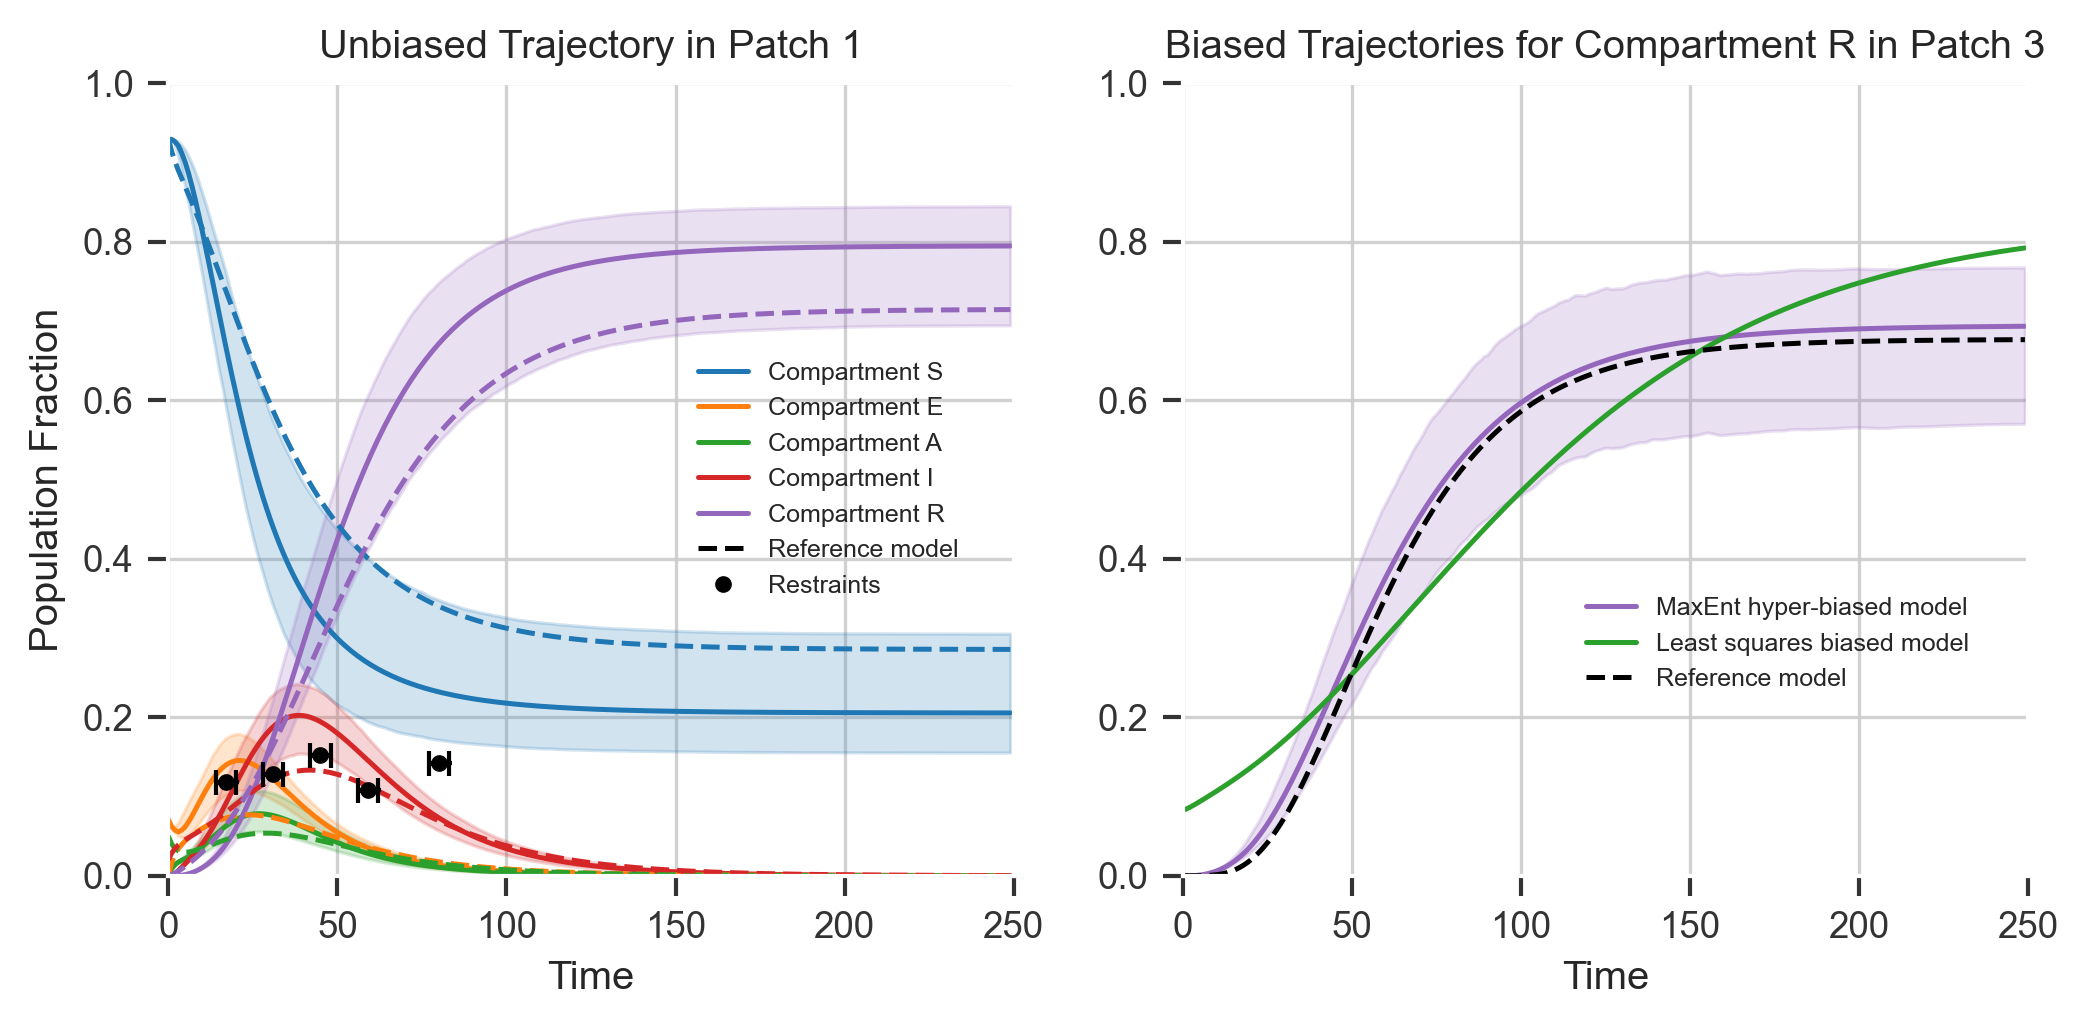

In [32]:
plt.rc('axes', titlesize=8)

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), dpi =300)

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'Unbiased Trajectory in Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(0.6,0.5), fontsize=6)


plt.setp(axs[1], xlabel='Time', title = 'Biased Trajectories for Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(qtrajs_hyperbiased.shape)
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= 'C4',  label='MaxEnt hyper-biased model')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='C4', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= 'C2',  label='Least squares biased model')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Reference model')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
plt.savefig('neurips.png', transparent=False, dpi = 300)


In [486]:
class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            self. i = 0
        def on_epoch_begin(self, epoch, logs=None):
            self.i += 1
            return self.i

In [487]:
# import logging
# tf.get_logger().setLevel(logging.ERROR)
history = abc.run(minimum_epsilon=0.2, max_nr_populations=5)

250/250 [==============================] - 49s 195ms/step - loss: 0.0018 - output_2_loss: 0.0018
Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - ref-error-metric: 0.2059 - ref-error: 0.2059 - weight-entropy: 9.0056
Epoch 2/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0043 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 9.0058
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - ref-error-metric: 0.2053 - ref-error: 0.2053 - weight-entropy: 9.0059
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - ref-error-metric: 0.2057 - ref-error: 0.2057 - weight-entropy: 9.0060
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - ref-error-metric: 0.2054 - ref-error: 0.2054 - weight-entropy: 9.0061
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0043 - ref-error-metric: 0.2060 - ref-error: 0.2060 - weight-entropy: 9.

1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 9.0081
Epoch 55/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - ref-error-metric: 0.2056 - ref-error: 0.2056 - weight-entropy: 9.0080
Epoch 56/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 9.0080
Epoch 57/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - ref-error-metric: 0.2052 - ref-error: 0.2052 - weight-entropy: 9.0079
Epoch 58/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0039 - ref-error-metric: 0.2051 - ref-error: 0.2051 - weight-entropy: 9.0079
Epoch 59/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - ref-error-metric: 0.2055 - ref-error: 0.2055 - weight-entropy: 9.0078
Epoch 60/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - ref-error-metric: 

In [59]:
print (restraints)
print(hme_model.trajs.shape)

1/1 [==============================] - 0s 995us/step - loss: 0.0031 - ref-error-metric: 0.2043 - ref-error: 0.2043 - weight-entropy: 8.9861
Epoch 161/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - ref-error-metric: 0.2056 - ref-error: 0.2056 - weight-entropy: 8.9858
Epoch 162/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0031 - ref-error-metric: 0.2060 - ref-error: 0.2060 - weight-entropy: 8.9854
Epoch 163/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - ref-error-metric: 0.2053 - ref-error: 0.2053 - weight-entropy: 8.9850
Epoch 164/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - ref-error-metric: 0.2065 - ref-error: 0.2065 - weight-entropy: 8.9846
Epoch 165/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - ref-error-metric: 0.2033 - ref-error: 0.2033 - weight-entropy: 8.9843
Epoch 166/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0031 - ref-erro

1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 0.2080 - ref-error: 0.2080 - weight-entropy: 8.9327
Epoch 267/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 0.2051 - ref-error: 0.2051 - weight-entropy: 8.9321
Epoch 268/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 0.2030 - ref-error: 0.2030 - weight-entropy: 8.9315
Epoch 269/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0026 - ref-error-metric: 0.2085 - ref-error: 0.2085 - weight-entropy: 8.9309
Epoch 270/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0025 - ref-error-metric: 0.2116 - ref-error: 0.2116 - weight-entropy: 8.9302
Epoch 271/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0025 - ref-error-metric: 0.2050 - ref-error: 0.2050 - weight-entropy: 8.9296
Epoch 272/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0025 - ref-erro

1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-error-metric: 0.2084 - ref-error: 0.2084 - weight-entropy: 8.8603
Epoch 373/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0022 - ref-error-metric: 0.2088 - ref-error: 0.2088 - weight-entropy: 8.8596
Epoch 374/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0022 - ref-error-metric: 0.1981 - ref-error: 0.1981 - weight-entropy: 8.8589
Epoch 375/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-error-metric: 0.2084 - ref-error: 0.2084 - weight-entropy: 8.8581
Epoch 376/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-error-metric: 0.2050 - ref-error: 0.2050 - weight-entropy: 8.8574
Epoch 377/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0022 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 8.8567
Epoch 378/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-erro

1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - ref-error-metric: 0.1986 - ref-error: 0.1986 - weight-entropy: 8.7855
Epoch 479/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 0.2111 - ref-error: 0.2111 - weight-entropy: 8.7848
Epoch 480/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 8.7842
Epoch 481/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 0.2048 - ref-error: 0.2048 - weight-entropy: 8.7835
Epoch 482/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-error-metric: 0.2038 - ref-error: 0.2038 - weight-entropy: 8.7828
Epoch 483/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-error-metric: 0.2002 - ref-error: 0.2002 - weight-entropy: 8.7822
Epoch 484/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-

1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2036 - ref-error: 0.2036 - weight-entropy: 8.7210
Epoch 585/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 0.1985 - ref-error: 0.1985 - weight-entropy: 8.7205
Epoch 586/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2064 - ref-error: 0.2064 - weight-entropy: 8.7200
Epoch 587/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2025 - ref-error: 0.2025 - weight-entropy: 8.7194
Epoch 588/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2046 - ref-error: 0.2046 - weight-entropy: 8.7189
Epoch 589/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 0.2033 - ref-error: 0.2033 - weight-entropy: 8.7184
Epoch 590/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-

1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-error-metric: 0.2057 - ref-error: 0.2057 - weight-entropy: 8.6708
Epoch 691/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 8.6704
Epoch 692/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 0.1968 - ref-error: 0.1968 - weight-entropy: 8.6700
Epoch 693/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - ref-error-metric: 0.2196 - ref-error: 0.2196 - weight-entropy: 8.6696
Epoch 694/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 0.2079 - ref-error: 0.2079 - weight-entropy: 8.6692
Epoch 695/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0016 - ref-error-metric: 0.2026 - ref-error: 0.2026 - weight-entropy: 8.6688
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-er

1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 0.2057 - ref-error: 0.2057 - weight-entropy: 8.6318
Epoch 797/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 0.2026 - ref-error: 0.2026 - weight-entropy: 8.6315
Epoch 798/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 0.2116 - ref-error: 0.2116 - weight-entropy: 8.6311
Epoch 799/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 0.1959 - ref-error: 0.1959 - weight-entropy: 8.6308
Epoch 800/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - ref-error-metric: 0.2131 - ref-error: 0.2131 - weight-entropy: 8.6305
Epoch 801/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2051 - ref-error: 0.2051 - weight-entropy: 8.6301
Epoch 802/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metr

1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.1971 - ref-error: 0.1971 - weight-entropy: 8.5991
Epoch 903/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2021 - ref-error: 0.2021 - weight-entropy: 8.5989
Epoch 904/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.1979 - ref-error: 0.1979 - weight-entropy: 8.5986
Epoch 905/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0015 - ref-error-metric: 0.2055 - ref-error: 0.2055 - weight-entropy: 8.5983
Epoch 906/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.1972 - ref-error: 0.1972 - weight-entropy: 8.5980
Epoch 907/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2123 - ref-error: 0.2123 - weight-entropy: 8.5977
Epoch 908/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-me

1/1 [==============================] - 0s 1ms/step - loss: 0.0036 - ref-error-metric: 0.2053 - ref-error: 0.2053 - weight-entropy: 9.0102
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0036 - ref-error-metric: 0.2053 - ref-error: 0.2053 - weight-entropy: 9.0103
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - ref-error-metric: 0.2056 - ref-error: 0.2056 - weight-entropy: 9.0103
Epoch 10/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - ref-error-metric: 0.2054 - ref-error: 0.2054 - weight-entropy: 9.0103
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0036 - ref-error-metric: 0.2052 - ref-error: 0.2052 - weight-entropy: 9.0104
Epoch 12/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0036 - ref-error-metric: 0.2053 - ref-error: 0.2053 - weight-entropy: 9.0104
Epoch 13/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0035 - ref-error-metric: 

1/1 [==============================] - 0s 2ms/step - loss: 0.0029 - ref-error-metric: 0.2041 - ref-error: 0.2041 - weight-entropy: 8.9980
Epoch 114/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0029 - ref-error-metric: 0.2043 - ref-error: 0.2043 - weight-entropy: 8.9977
Epoch 115/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0029 - ref-error-metric: 0.2060 - ref-error: 0.2060 - weight-entropy: 8.9974
Epoch 116/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0029 - ref-error-metric: 0.2054 - ref-error: 0.2054 - weight-entropy: 8.9972
Epoch 117/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.0029 - ref-error-metric: 0.2062 - ref-error: 0.2062 - weight-entropy: 8.9969
Epoch 118/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0029 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.9966
Epoch 119/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0029 - ref-e

1/1 [==============================] - 0s 1ms/step - loss: 0.0024 - ref-error-metric: 0.2072 - ref-error: 0.2072 - weight-entropy: 8.9549
Epoch 220/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0024 - ref-error-metric: 0.2041 - ref-error: 0.2041 - weight-entropy: 8.9544
Epoch 221/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - ref-error-metric: 0.2072 - ref-error: 0.2072 - weight-entropy: 8.9538
Epoch 222/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.9533
Epoch 223/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0024 - ref-error-metric: 0.2034 - ref-error: 0.2034 - weight-entropy: 8.9527
Epoch 224/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - ref-error-metric: 0.2030 - ref-error: 0.2030 - weight-entropy: 8.9522
Epoch 225/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0024 - ref-error-

1/1 [==============================] - 0s 998us/step - loss: 0.0021 - ref-error-metric: 0.2025 - ref-error: 0.2025 - weight-entropy: 8.8907
Epoch 324/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 0.2078 - ref-error: 0.2078 - weight-entropy: 8.8901
Epoch 325/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0020 - ref-error-metric: 0.2040 - ref-error: 0.2040 - weight-entropy: 8.8894
Epoch 326/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - ref-error-metric: 0.2061 - ref-error: 0.2061 - weight-entropy: 8.8887
Epoch 327/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - ref-error-metric: 0.2027 - ref-error: 0.2027 - weight-entropy: 8.8880
Epoch 328/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 0.2030 - ref-error: 0.2030 - weight-entropy: 8.8873
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - ref-erro

1/1 [==============================] - 0s 999us/step - loss: 0.0018 - ref-error-metric: 0.2024 - ref-error: 0.2024 - weight-entropy: 8.8169
Epoch 430/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2075 - ref-error: 0.2075 - weight-entropy: 8.8162
Epoch 431/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2035 - ref-error: 0.2035 - weight-entropy: 8.8155
Epoch 432/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2029 - ref-error: 0.2029 - weight-entropy: 8.8148
Epoch 433/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 0.2064 - ref-error: 0.2064 - weight-entropy: 8.8141
Epoch 434/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 0.2070 - ref-error: 0.2070 - weight-entropy: 8.8135
Epoch 435/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-erro

1/1 [==============================] - 0s 999us/step - loss: 0.0016 - ref-error-metric: 0.2126 - ref-error: 0.2126 - weight-entropy: 8.7479
Epoch 536/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-error-metric: 0.2014 - ref-error: 0.2014 - weight-entropy: 8.7473
Epoch 537/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 0.1993 - ref-error: 0.1993 - weight-entropy: 8.7467
Epoch 538/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 0.2016 - ref-error: 0.2016 - weight-entropy: 8.7461
Epoch 539/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 0.2116 - ref-error: 0.2116 - weight-entropy: 8.7455
Epoch 540/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 0.2063 - ref-error: 0.2063 - weight-entropy: 8.7449
Epoch 541/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-

1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2103 - ref-error: 0.2103 - weight-entropy: 8.6909
Epoch 641/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2005 - ref-error: 0.2005 - weight-entropy: 8.6904
Epoch 642/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2039 - ref-error: 0.2039 - weight-entropy: 8.6899
Epoch 643/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2022 - ref-error: 0.2022 - weight-entropy: 8.6895
Epoch 644/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2102 - ref-error: 0.2102 - weight-entropy: 8.6890
Epoch 645/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0015 - ref-error-metric: 0.2090 - ref-error: 0.2090 - weight-entropy: 8.6885
Epoch 646/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-me

1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2081 - ref-error: 0.2081 - weight-entropy: 8.6448
Epoch 747/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2089 - ref-error: 0.2089 - weight-entropy: 8.6444
Epoch 748/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2102 - ref-error: 0.2102 - weight-entropy: 8.6440
Epoch 749/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2107 - ref-error: 0.2107 - weight-entropy: 8.6436
Epoch 750/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2103 - ref-error: 0.2103 - weight-entropy: 8.6432
Epoch 751/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2011 - ref-error: 0.2011 - weight-entropy: 8.6429
Epoch 752/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metr

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.6071
Epoch 853/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0014 - ref-error-metric: 0.2102 - ref-error: 0.2102 - weight-entropy: 8.6067
Epoch 854/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.1941 - ref-error: 0.1941 - weight-entropy: 8.6064
Epoch 855/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.2029 - ref-error: 0.2029 - weight-entropy: 8.6061
Epoch 856/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.1999 - ref-error: 0.1999 - weight-entropy: 8.6058
Epoch 857/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0014 - ref-error-metric: 0.2077 - ref-error: 0.2077 - weight-entropy: 8.6054
Epoch 858/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - ref-error-

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - ref-error-metric: 0.2113 - ref-error: 0.2113 - weight-entropy: 8.5752
Epoch 959/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0014 - ref-error-metric: 0.2041 - ref-error: 0.2041 - weight-entropy: 8.5749
Epoch 960/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - ref-error-metric: 0.2032 - ref-error: 0.2032 - weight-entropy: 8.5746
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.2060 - ref-error: 0.2060 - weight-entropy: 8.5743
Epoch 962/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - ref-error-metric: 0.2004 - ref-error: 0.2004 - weight-entropy: 8.5740
Epoch 963/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.2093 - ref-error: 0.2093 - weight-entropy: 8.5738
Epoch 964/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - ref-error-me

Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0036 - ref-error-metric: 0.2054 - ref-error: 0.2054 - weight-entropy: 9.0045
Epoch 12/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - ref-error-metric: 0.2052 - ref-error: 0.2052 - weight-entropy: 9.0043
Epoch 13/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0036 - ref-error-metric: 0.2064 - ref-error: 0.2064 - weight-entropy: 9.0041
Epoch 14/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - ref-error-metric: 0.2056 - ref-error: 0.2056 - weight-entropy: 9.0038
Epoch 15/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0035 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 9.0036
Epoch 16/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0035 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 9.0034
Epoch 17/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - ref

1/1 [==============================] - 0s 998us/step - loss: 0.0028 - ref-error-metric: 0.2046 - ref-error: 0.2046 - weight-entropy: 8.9644
Epoch 118/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0028 - ref-error-metric: 0.2044 - ref-error: 0.2044 - weight-entropy: 8.9639
Epoch 119/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0028 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 8.9633
Epoch 120/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0028 - ref-error-metric: 0.2056 - ref-error: 0.2056 - weight-entropy: 8.9628
Epoch 121/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0027 - ref-error-metric: 0.2041 - ref-error: 0.2041 - weight-entropy: 8.9622
Epoch 122/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0027 - ref-error-metric: 0.2072 - ref-error: 0.2072 - weight-entropy: 8.9617
Epoch 123/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0027 - ref-error-me

1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 8.8924
Epoch 223/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - ref-error-metric: 0.2035 - ref-error: 0.2035 - weight-entropy: 8.8916
Epoch 224/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - ref-error-metric: 0.2080 - ref-error: 0.2080 - weight-entropy: 8.8908
Epoch 225/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 0.2055 - ref-error: 0.2055 - weight-entropy: 8.8900
Epoch 226/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 0.2055 - ref-error: 0.2055 - weight-entropy: 8.8892
Epoch 227/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - ref-error-metric: 0.2044 - ref-error: 0.2044 - weight-entropy: 8.8884
Epoch 228/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - ref-error-m

1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 8.7993
Epoch 328/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0017 - ref-error-metric: 0.2032 - ref-error: 0.2032 - weight-entropy: 8.7984
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 0.1999 - ref-error: 0.1999 - weight-entropy: 8.7975
Epoch 330/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 0.2183 - ref-error: 0.2183 - weight-entropy: 8.7965
Epoch 331/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-metric: 0.2063 - ref-error: 0.2063 - weight-entropy: 8.7956
Epoch 332/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 0.2044 - ref-error: 0.2044 - weight-entropy: 8.7946
Epoch 333/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-erro

In [34]:
plt.rc('axes', titlesize=8)

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), dpi =300)

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'Unbiased Trajectory in Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(0.6,0.5), fontsize=6)


plt.setp(axs[1], xlabel='Time', title = 'Biased Trajectories for Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(qtrajs_hyperbiased.shape)
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= 'C4',  label='MaxEnt hyper-biased model')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='C4', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= 'C2',  label='Least squares biased model')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Reference model')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
plt.savefig('neurips.png', transparent=False, dpi = 300)


1/1 [==============================] - 0s 997us/step - loss: 0.0014 - ref-error-metric: 0.2030 - ref-error: 0.2030 - weight-entropy: 8.6986
Epoch 434/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.2007 - ref-error: 0.2007 - weight-entropy: 8.6976
Epoch 435/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0014 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 8.6967
Epoch 436/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0014 - ref-error-metric: 0.2143 - ref-error: 0.2143 - weight-entropy: 8.6958
Epoch 437/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.1983 - ref-error: 0.1983 - weight-entropy: 8.6948
Epoch 438/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0014 - ref-error-metric: 0.2053 - ref-error: 0.2053 - weight-entropy: 8.6939
Epoch 439/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - ref-erro

1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.1986 - ref-error: 0.1986 - weight-entropy: 8.6040
Epoch 540/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2117 - ref-error: 0.2117 - weight-entropy: 8.6032
Epoch 541/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.1975 - ref-error: 0.1975 - weight-entropy: 8.6023
Epoch 542/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 8.6015
Epoch 543/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.1973 - ref-error: 0.1973 - weight-entropy: 8.6007
Epoch 544/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.1993 - ref-error: 0.1993 - weight-entropy: 8.5998
Epoch 545/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metr

In [33]:
print (restraints)
print(hme_model.trajs.shape)

1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-metric: 0.1981 - ref-error: 0.1981 - weight-entropy: 8.5241
Epoch 646/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-metric: 0.2128 - ref-error: 0.2128 - weight-entropy: 8.5235
Epoch 647/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2104 - ref-error: 0.2104 - weight-entropy: 8.5228
Epoch 648/1000
1/1 [==============================] - 0s 978us/step - loss: 0.0011 - ref-error-metric: 0.2028 - ref-error: 0.2028 - weight-entropy: 8.5221
Epoch 649/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0011 - ref-error-metric: 0.2021 - ref-error: 0.2021 - weight-entropy: 8.5215
Epoch 650/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2044 - ref-error: 0.2044 - weight-entropy: 8.5208
Epoch 651/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-

1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2065 - ref-error: 0.2065 - weight-entropy: 8.4625
Epoch 752/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.1956 - ref-error: 0.1956 - weight-entropy: 8.4620
Epoch 753/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.1994 - ref-error: 0.1994 - weight-entropy: 8.4615
Epoch 754/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2088 - ref-error: 0.2088 - weight-entropy: 8.4610
Epoch 755/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.1925 - ref-error: 0.1925 - weight-entropy: 8.4605
Epoch 756/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0011 - ref-error-metric: 0.1966 - ref-error: 0.1966 - weight-entropy: 8.4600
Epoch 757/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-

In [34]:
LS_sample_trajs = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
MaxEnt_sample_trajs = np.empty_like(LS_sample_trajs)
HyperMaxEnt_sample_trajs = np.empty_like(LS_sample_trajs)
for i in range(npoints):
    sampled_restraints = [n for n in restraints if n != restraints[i]]
    def new_agreement(traj, rs=sampled_restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel_sampled = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, new_agreement)
    rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj_sampled = rmodel_sampled.get_traj()
    rmodel_sampled.fit(timesteps)
    regressed_traj_sampled = rmodel_sampled.get_traj()
    LS_sample_trajs[i,:,:,:] = regressed_traj_sampled
    
    ## MaxEnt
    me_model_sample = maxentep.MaxentModel(sampled_restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
    me_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
    me_history_sample = me_model_sample.fit(trajs, batch_size=batch_size,epochs=1000, callbacks=[CustomCallback()])
    MaxEnt_sample_trajs[i,:,:,:] = np.sum(me_model_sample.trajs * me_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
    
    ## Hyper-MaxEnt
#     hme_model_sample = maxentep.HyperMaxentModel(sampled_restraints, fit_param_model, model, reweight=False)
#     hme_model_sample.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
#     hme_history_sample = hme_model_sample.fit(
#     N, final_batch_multiplier=batches, 
#     outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)
#     hme_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
#     # hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
#     hme_final_history_sample = hme_model_sample.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)
#     HyperMaxEnt_sample_trajs[i,:,:,:] = np.sum(hme_model_sample.trajs * hme_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)

1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-metric: 0.2126 - ref-error: 0.2126 - weight-entropy: 8.4184
Epoch 858/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2021 - ref-error: 0.2021 - weight-entropy: 8.4181
Epoch 859/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-metric: 0.1941 - ref-error: 0.1941 - weight-entropy: 8.4178
Epoch 860/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0011 - ref-error-metric: 0.2056 - ref-error: 0.2056 - weight-entropy: 8.4174
Epoch 861/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2066 - ref-error: 0.2066 - weight-entropy: 8.4171
Epoch 862/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-metric: 0.2066 - ref-error: 0.2066 - weight-entropy: 8.4168
Epoch 863/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-

Epoch 963/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.1969 - ref-error: 0.1969 - weight-entropy: 8.3891
Epoch 964/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2039 - ref-error: 0.2039 - weight-entropy: 8.3889
Epoch 965/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0011 - ref-error-metric: 0.2103 - ref-error: 0.2103 - weight-entropy: 8.3887
Epoch 966/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0011 - ref-error-metric: 0.2067 - ref-error: 0.2067 - weight-entropy: 8.3884
Epoch 967/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2028 - ref-error: 0.2028 - weight-entropy: 8.3882
Epoch 968/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2258 - ref-error: 0.2258 - weight-entropy: 8.3880
Epoch 969/1000
1/1 [==============================] - 0s 997us/step - loss: 0.

1/1 [==============================] - 0s 998us/step - loss: 9.0744e-04 - ref-error-metric: 0.2031 - ref-error: 0.2031 - weight-entropy: 8.9888
Epoch 69/1000
1/1 [==============================] - 0s 998us/step - loss: 9.0214e-04 - ref-error-metric: 0.2048 - ref-error: 0.2048 - weight-entropy: 8.9884
Epoch 70/1000
1/1 [==============================] - 0s 998us/step - loss: 8.9686e-04 - ref-error-metric: 0.2063 - ref-error: 0.2063 - weight-entropy: 8.9880
Epoch 71/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.9161e-04 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 8.9875
Epoch 72/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.8638e-04 - ref-error-metric: 0.2063 - ref-error: 0.2063 - weight-entropy: 8.9871
Epoch 73/1000
1/1 [==============================] - 0s 1ms/step - loss: 8.8117e-04 - ref-error-metric: 0.2059 - ref-error: 0.2059 - weight-entropy: 8.9867
Epoch 74/1000
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 2ms/step - loss: 4.8741e-04 - ref-error-metric: 0.2035 - ref-error: 0.2035 - weight-entropy: 8.9337
Epoch 172/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.8450e-04 - ref-error-metric: 0.2031 - ref-error: 0.2031 - weight-entropy: 8.9330
Epoch 173/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.8162e-04 - ref-error-metric: 0.2052 - ref-error: 0.2052 - weight-entropy: 8.9324
Epoch 174/1000
1/1 [==============================] - 0s 0s/step - loss: 4.7875e-04 - ref-error-metric: 0.2078 - ref-error: 0.2078 - weight-entropy: 8.9318
Epoch 175/1000
1/1 [==============================] - 0s 998us/step - loss: 4.7591e-04 - ref-error-metric: 0.2062 - ref-error: 0.2062 - weight-entropy: 8.9311
Epoch 176/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.7309e-04 - ref-error-metric: 0.2073 - ref-error: 0.2073 - weight-entropy: 8.9305
Epoch 177/1000
1/1 [==============================] - 0s 997us/step - lo

1/1 [==============================] - 0s 2ms/step - loss: 2.8028e-04 - ref-error-metric: 0.2016 - ref-error: 0.2016 - weight-entropy: 8.8671
Epoch 276/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7906e-04 - ref-error-metric: 0.2000 - ref-error: 0.2000 - weight-entropy: 8.8664
Epoch 277/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7786e-04 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.8658
Epoch 278/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7668e-04 - ref-error-metric: 0.2004 - ref-error: 0.2004 - weight-entropy: 8.8652
Epoch 279/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7550e-04 - ref-error-metric: 0.2033 - ref-error: 0.2033 - weight-entropy: 8.8646
Epoch 280/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.7433e-04 - ref-error-metric: 0.2012 - ref-error: 0.2012 - weight-entropy: 8.8640
Epoch 281/1000
1/1 [==============================] - 0s 3ms/step - loss:

1/1 [==============================] - 0s 1ms/step - loss: 2.0381e-04 - ref-error-metric: 0.2081 - ref-error: 0.2081 - weight-entropy: 8.8111
Epoch 380/1000
1/1 [==============================] - 0s 996us/step - loss: 2.0343e-04 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.8107
Epoch 381/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0307e-04 - ref-error-metric: 0.1980 - ref-error: 0.1980 - weight-entropy: 8.8102
Epoch 382/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0270e-04 - ref-error-metric: 0.2021 - ref-error: 0.2021 - weight-entropy: 8.8098
Epoch 383/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0234e-04 - ref-error-metric: 0.2040 - ref-error: 0.2040 - weight-entropy: 8.8094
Epoch 384/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0199e-04 - ref-error-metric: 0.2105 - ref-error: 0.2105 - weight-entropy: 8.8089
Epoch 385/1000
1/1 [==============================] - 0s 971us/step - l

1/1 [==============================] - 0s 997us/step - loss: 1.8966e-04 - ref-error-metric: 0.2060 - ref-error: 0.2060 - weight-entropy: 8.7907
Epoch 432/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8947e-04 - ref-error-metric: 0.2100 - ref-error: 0.2100 - weight-entropy: 8.7904
Epoch 433/1000
1/1 [==============================] - 0s 998us/step - loss: 1.8929e-04 - ref-error-metric: 0.2105 - ref-error: 0.2105 - weight-entropy: 8.7900
Epoch 434/1000
1/1 [==============================] - 0s 998us/step - loss: 1.8911e-04 - ref-error-metric: 0.2059 - ref-error: 0.2059 - weight-entropy: 8.7897
Epoch 435/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8893e-04 - ref-error-metric: 0.2015 - ref-error: 0.2015 - weight-entropy: 8.7894
Epoch 436/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8876e-04 - ref-error-metric: 0.2101 - ref-error: 0.2101 - weight-entropy: 8.7890
Epoch 437/1000
1/1 [==============================] - 0s 1ms/step -

1/1 [==============================] - 0s 2ms/step - loss: 1.8287e-04 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.7755
Epoch 484/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8278e-04 - ref-error-metric: 0.2068 - ref-error: 0.2068 - weight-entropy: 8.7752
Epoch 485/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8270e-04 - ref-error-metric: 0.2077 - ref-error: 0.2077 - weight-entropy: 8.7750
Epoch 486/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.8262e-04 - ref-error-metric: 0.2013 - ref-error: 0.2013 - weight-entropy: 8.7747
Epoch 487/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.8254e-04 - ref-error-metric: 0.2073 - ref-error: 0.2073 - weight-entropy: 8.7745
Epoch 488/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.8245e-04 - ref-error-metric: 0.2099 - ref-error: 0.2099 - weight-entropy: 8.7742
Epoch 489/1000
1/1 [==============================] - 0s 997us/step - los

1/1 [==============================] - 0s 2ms/step - loss: 1.7849e-04 - ref-error-metric: 0.2053 - ref-error: 0.2053 - weight-entropy: 8.7575
Epoch 588/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7847e-04 - ref-error-metric: 0.2123 - ref-error: 0.2123 - weight-entropy: 8.7573
Epoch 589/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7846e-04 - ref-error-metric: 0.2066 - ref-error: 0.2066 - weight-entropy: 8.7572
Epoch 590/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7844e-04 - ref-error-metric: 0.1993 - ref-error: 0.1993 - weight-entropy: 8.7571
Epoch 591/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7842e-04 - ref-error-metric: 0.2076 - ref-error: 0.2076 - weight-entropy: 8.7570
Epoch 592/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7841e-04 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 8.7569
Epoch 593/1000
1/1 [==============================] - 0s 1ms/step - loss:

Epoch 691/1000
1/1 [==============================] - 0s 998us/step - loss: 1.7759e-04 - ref-error-metric: 0.2133 - ref-error: 0.2133 - weight-entropy: 8.7500
Epoch 692/1000
1/1 [==============================] - 0s 998us/step - loss: 1.7759e-04 - ref-error-metric: 0.2106 - ref-error: 0.2106 - weight-entropy: 8.7500
Epoch 693/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7758e-04 - ref-error-metric: 0.2044 - ref-error: 0.2044 - weight-entropy: 8.7499
Epoch 694/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7758e-04 - ref-error-metric: 0.2062 - ref-error: 0.2062 - weight-entropy: 8.7499
Epoch 695/1000
1/1 [==============================] - 0s 998us/step - loss: 1.7757e-04 - ref-error-metric: 0.2062 - ref-error: 0.2062 - weight-entropy: 8.7498
Epoch 696/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7757e-04 - ref-error-metric: 0.2046 - ref-error: 0.2046 - weight-entropy: 8.7498
Epoch 697/1000
1/1 [==============================] 

1/1 [==============================] - 0s 999us/step - loss: 1.7739e-04 - ref-error-metric: 0.2082 - ref-error: 0.2082 - weight-entropy: 8.7483
Epoch 744/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7739e-04 - ref-error-metric: 0.2060 - ref-error: 0.2060 - weight-entropy: 8.7483
Epoch 745/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7738e-04 - ref-error-metric: 0.2027 - ref-error: 0.2027 - weight-entropy: 8.7483
Epoch 746/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7738e-04 - ref-error-metric: 0.2045 - ref-error: 0.2045 - weight-entropy: 8.7483
Epoch 747/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7738e-04 - ref-error-metric: 0.2118 - ref-error: 0.2118 - weight-entropy: 8.7482
Epoch 748/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7737e-04 - ref-error-metric: 0.2051 - ref-error: 0.2051 - weight-entropy: 8.7482
Epoch 749/1000
1/1 [==============================] - 0s 2ms/step - los

1/1 [==============================] - 0s 998us/step - loss: 1.7706e-04 - ref-error-metric: 0.2026 - ref-error: 0.2026 - weight-entropy: 8.7469
Epoch 848/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7706e-04 - ref-error-metric: 0.2055 - ref-error: 0.2055 - weight-entropy: 8.7469
Epoch 849/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7706e-04 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 8.7469
Epoch 850/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7706e-04 - ref-error-metric: 0.2045 - ref-error: 0.2045 - weight-entropy: 8.7469
Epoch 851/1000
1/1 [==============================] - ETA: 0s - loss: 1.7705e-04 - ref-error-metric: 0.2101 - ref-error: 0.2101 - weight-entropy: 8.746 - 0s 1ms/step - loss: 1.7705e-04 - ref-error-metric: 0.2101 - ref-error: 0.2101 - weight-entropy: 8.7468
Epoch 852/1000
1/1 [==============================] - 0s 998us/step - loss: 1.7705e-04 - ref-error-metric: 0.2062 - ref-error: 0

1/1 [==============================] - 0s 1ms/step - loss: 1.7675e-04 - ref-error-metric: 0.1992 - ref-error: 0.1992 - weight-entropy: 8.7464
Epoch 951/1000
1/1 [==============================] - 0s 998us/step - loss: 1.7675e-04 - ref-error-metric: 0.2084 - ref-error: 0.2084 - weight-entropy: 8.7464
Epoch 952/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7675e-04 - ref-error-metric: 0.2062 - ref-error: 0.2062 - weight-entropy: 8.7464
Epoch 953/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7674e-04 - ref-error-metric: 0.2103 - ref-error: 0.2103 - weight-entropy: 8.7464
Epoch 954/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7674e-04 - ref-error-metric: 0.2062 - ref-error: 0.2062 - weight-entropy: 8.7464
Epoch 955/1000
1/1 [==============================] - 0s 997us/step - loss: 1.7674e-04 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 8.7464
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - l

1/1 [==============================] - 0s 997us/step - loss: 0.0032 - ref-error-metric: 0.2051 - ref-error: 0.2051 - weight-entropy: 9.0033
Epoch 55/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0032 - ref-error-metric: 0.2048 - ref-error: 0.2048 - weight-entropy: 9.0030
Epoch 56/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0032 - ref-error-metric: 0.2040 - ref-error: 0.2040 - weight-entropy: 9.0028
Epoch 57/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0032 - ref-error-metric: 0.2054 - ref-error: 0.2054 - weight-entropy: 9.0025
Epoch 58/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0031 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 9.0023
Epoch 59/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0031 - ref-error-metric: 0.2052 - ref-error: 0.2052 - weight-entropy: 9.0020
Epoch 60/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0031 - ref-error-metr

1/1 [==============================] - 0s 998us/step - loss: 0.0023 - ref-error-metric: 0.2063 - ref-error: 0.2063 - weight-entropy: 8.9561
Epoch 161/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0023 - ref-error-metric: 0.2030 - ref-error: 0.2030 - weight-entropy: 8.9555
Epoch 162/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - ref-error-metric: 0.2066 - ref-error: 0.2066 - weight-entropy: 8.9548
Epoch 163/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0023 - ref-error-metric: 0.2044 - ref-error: 0.2044 - weight-entropy: 8.9542
Epoch 164/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.9536
Epoch 165/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0023 - ref-error-metric: 0.2036 - ref-error: 0.2036 - weight-entropy: 8.9529
Epoch 166/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - ref-erro

1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 0.2082 - ref-error: 0.2082 - weight-entropy: 8.8776
Epoch 267/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2071 - ref-error: 0.2071 - weight-entropy: 8.8768
Epoch 268/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 0.2049 - ref-error: 0.2049 - weight-entropy: 8.8760
Epoch 269/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 0.2095 - ref-error: 0.2095 - weight-entropy: 8.8752
Epoch 270/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2069 - ref-error: 0.2069 - weight-entropy: 8.8744
Epoch 271/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 0.2086 - ref-error: 0.2086 - weight-entropy: 8.8735
Epoch 272/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-

1/1 [==============================] - 0s 997us/step - loss: 0.0015 - ref-error-metric: 0.2091 - ref-error: 0.2091 - weight-entropy: 8.7899
Epoch 373/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2059 - ref-error: 0.2059 - weight-entropy: 8.7891
Epoch 374/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2048 - ref-error: 0.2048 - weight-entropy: 8.7883
Epoch 375/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0015 - ref-error-metric: 0.2047 - ref-error: 0.2047 - weight-entropy: 8.7875
Epoch 376/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 0.2111 - ref-error: 0.2111 - weight-entropy: 8.7867
Epoch 377/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 0.2031 - ref-error: 0.2031 - weight-entropy: 8.7859
Epoch 378/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-

1/1 [==============================] - 0s 997us/step - loss: 0.0013 - ref-error-metric: 0.1993 - ref-error: 0.1993 - weight-entropy: 8.7114
Epoch 479/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - ref-error-metric: 0.2101 - ref-error: 0.2101 - weight-entropy: 8.7107
Epoch 480/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - ref-error-metric: 0.2065 - ref-error: 0.2065 - weight-entropy: 8.7100
Epoch 481/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - ref-error-metric: 0.2003 - ref-error: 0.2003 - weight-entropy: 8.7094
Epoch 482/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0013 - ref-error-metric: 0.2070 - ref-error: 0.2070 - weight-entropy: 8.7087
Epoch 483/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - ref-error-metric: 0.1965 - ref-error: 0.1965 - weight-entropy: 8.7081
Epoch 484/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - ref-error-

1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2085 - ref-error: 0.2085 - weight-entropy: 8.6508
Epoch 585/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2002 - ref-error: 0.2002 - weight-entropy: 8.6503
Epoch 586/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2051 - ref-error: 0.2051 - weight-entropy: 8.6498
Epoch 587/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2077 - ref-error: 0.2077 - weight-entropy: 8.6493
Epoch 588/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2120 - ref-error: 0.2120 - weight-entropy: 8.6489
Epoch 589/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.1986 - ref-error: 0.1986 - weight-entropy: 8.6484
Epoch 590/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metr

1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2074 - ref-error: 0.2074 - weight-entropy: 8.6088
Epoch 691/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2069 - ref-error: 0.2069 - weight-entropy: 8.6085
Epoch 692/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2090 - ref-error: 0.2090 - weight-entropy: 8.6082
Epoch 693/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0012 - ref-error-metric: 0.2129 - ref-error: 0.2129 - weight-entropy: 8.6079
Epoch 694/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2022 - ref-error: 0.2022 - weight-entropy: 8.6076
Epoch 695/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2073 - ref-error: 0.2073 - weight-entropy: 8.6073
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-me

1/1 [==============================] - 0s 998us/step - loss: 0.0012 - ref-error-metric: 0.2020 - ref-error: 0.2020 - weight-entropy: 8.5817
Epoch 797/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-error-metric: 0.2164 - ref-error: 0.2164 - weight-entropy: 8.5815
Epoch 798/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0012 - ref-error-metric: 0.2127 - ref-error: 0.2127 - weight-entropy: 8.5813
Epoch 799/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2017 - ref-error: 0.2017 - weight-entropy: 8.5811
Epoch 800/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0012 - ref-error-metric: 0.2058 - ref-error: 0.2058 - weight-entropy: 8.5809
Epoch 801/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - ref-error-metric: 0.2071 - ref-error: 0.2071 - weight-entropy: 8.5807
Epoch 802/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - ref-erro

1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2011 - ref-error: 0.2011 - weight-entropy: 8.5643
Epoch 903/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.1996 - ref-error: 0.1996 - weight-entropy: 8.5642
Epoch 904/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2071 - ref-error: 0.2071 - weight-entropy: 8.5641
Epoch 905/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - ref-error-metric: 0.2070 - ref-error: 0.2070 - weight-entropy: 8.5640
Epoch 906/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2102 - ref-error: 0.2102 - weight-entropy: 8.5638
Epoch 907/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - ref-error-metric: 0.2124 - ref-error: 0.2124 - weight-entropy: 8.5637
Epoch 908/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - ref-error-me

In [492]:
# np.save('HyperMaxEnt_sample_trajs',HyperMaxEnt_sample_trajs)
np.save('LS_sample_trajs_new',LS_sample_trajs)
np.save('MaxEnt_sample_trajs_new',MaxEnt_sample_trajs)

0.00010313597726591281
0.0033760122746683977


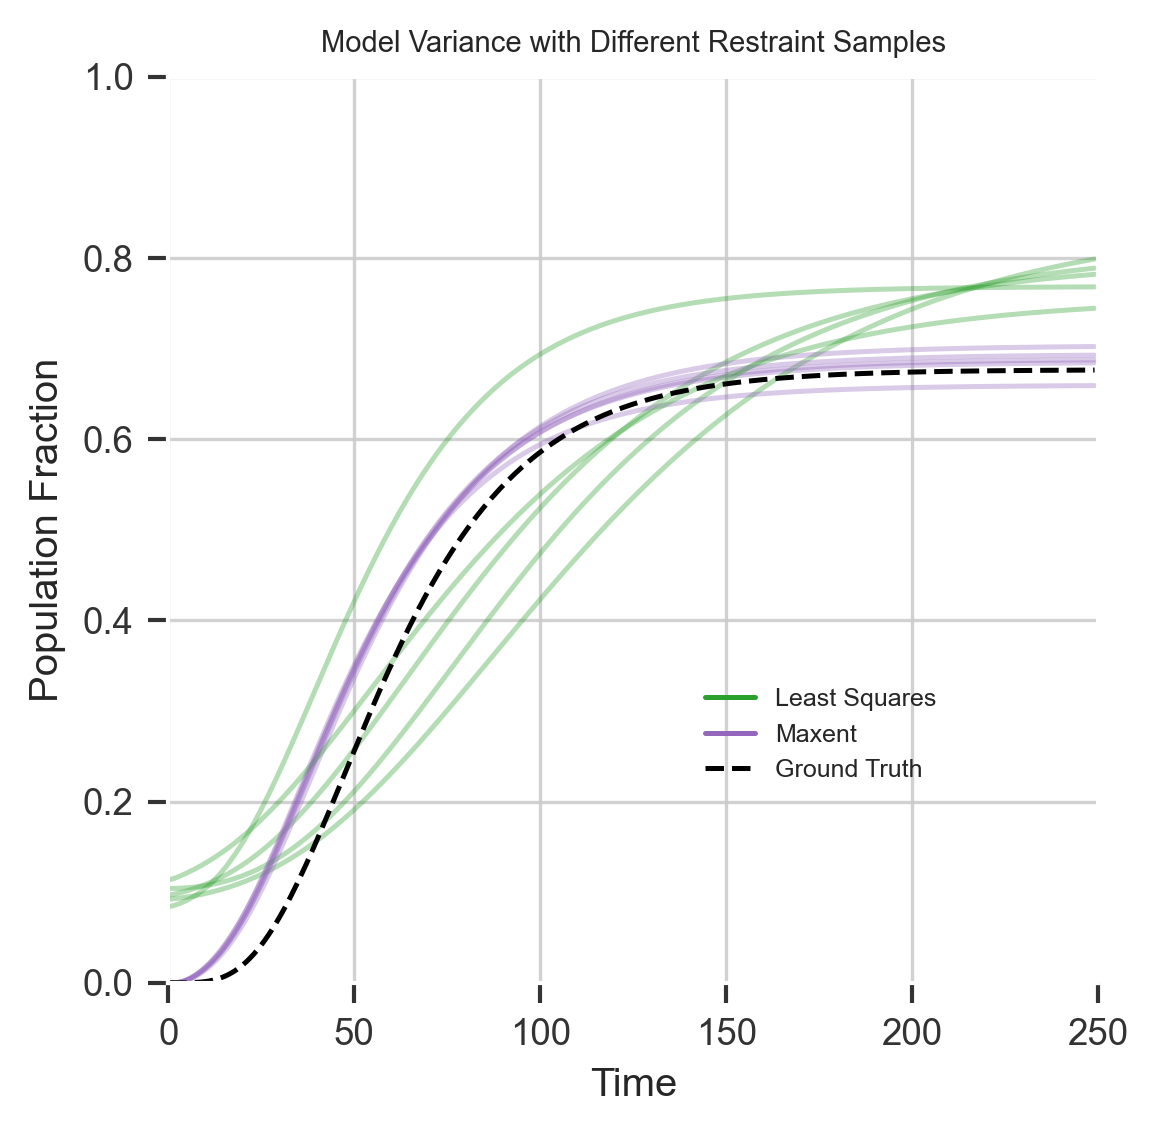

In [493]:
MaxEnt_sample_trajs = np.load('MaxEnt_sample_trajs.npy')
LS_sample_trajs = np.load('LS_sample_trajs.npy')
fig, ax = plt.subplots(figsize=(4,4), dpi=300) 
plt.rc('axes', titlesize=7)
plt.setp(plt.gca(), ylabel='Population Fraction' ,xlabel='Time', title = "Model Variance with Different Restraint Samples", xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for i,y in enumerate(LS_sample_trajs):
    plt.plot(x, y[:,2,4], color= 'C2', alpha=0.35)
    plt.plot(x, MaxEnt_sample_trajs[i,:,2,4], color= 'C4', alpha=0.35)
plt.plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Ground Truth')
plt.legend(bbox_to_anchor=(0.65,0.45), fontsize=6)
hand, labl = ax.get_legend_handles_labels()
predicted_label_LS = 'Least Squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='C2')
predicted_label_HM = 'Maxent'
predicted_line_HM = plt.Line2D((0,1),(0,0), color='C4')
plt.legend([predicted_line_LS, predicted_line_HM]+[handle for i,handle in enumerate(hand)],
              [predicted_label_LS, predicted_label_HM]+[label for i,label in enumerate(labl)]
                , bbox_to_anchor=(0.85,0.35), fontsize=6)
plt.savefig('neurips_LS.png', transparent=False, dpi = 300)

print(np.mean(np.var(MaxEnt_sample_trajs[:,:,2,4], axis=0)))
print(np.mean(np.var(LS_sample_trajs[:,:,2,4], axis=0)))


In [541]:
abc_sample_trajs = np.load('abc_traj_folds_new.npy')
sbi_sample_trajs = np.load('sbi_traj_folds.npy')
MaxEnt_sample_trajs = np.load('MaxEnt_sample_trajs_new.npy')
# LS_sample_trajs = np.load('LS_sample_trajs.npy')
LS_sample_trajs = np.load('LS_sample_trajs_new.npy')
def find_std(sample_trajs):
    std_0 = np.std(sample_trajs[:,0,2,4])
    std_mid = np.std(sample_trajs[:,125,2,4])
    std_end = np.std(sample_trajs[:,-1,2,4])
    return [std_0, std_mid, std_end]
    
std_abc = find_std(abc_sample_trajs)
std_sbi = find_std(sbi_sample_trajs)
std_MaxEnt = find_std(MaxEnt_sample_trajs)
std_LS = find_std(LS_sample_trajs)
print('MaxEnt std : ', std_MaxEnt)
print('Least-squares std : ', std_LS)
print('ABC std : ', std_abc)
print('SNLE std : ', std_sbi)

stds = np.array(np.round([std_MaxEnt, std_LS, std_abc, std_sbi],3))
print (stds)

MaxEnt std :  [0.0, 0.010362384893697492, 0.014377354909248337]
Least-squares std :  [0.010116065031543907, 0.06633849078631722, 0.018867484122472113]
ABC std :  [0.0, 0.01628512744747908, 0.02044885777211721]
SNLE std :  [0.0, 0.23478273589286525, 0.26162770979084016]
[[0.    0.01  0.014]
 [0.01  0.066 0.019]
 [0.    0.016 0.02 ]
 [0.    0.235 0.262]]


(250, 3, 5)


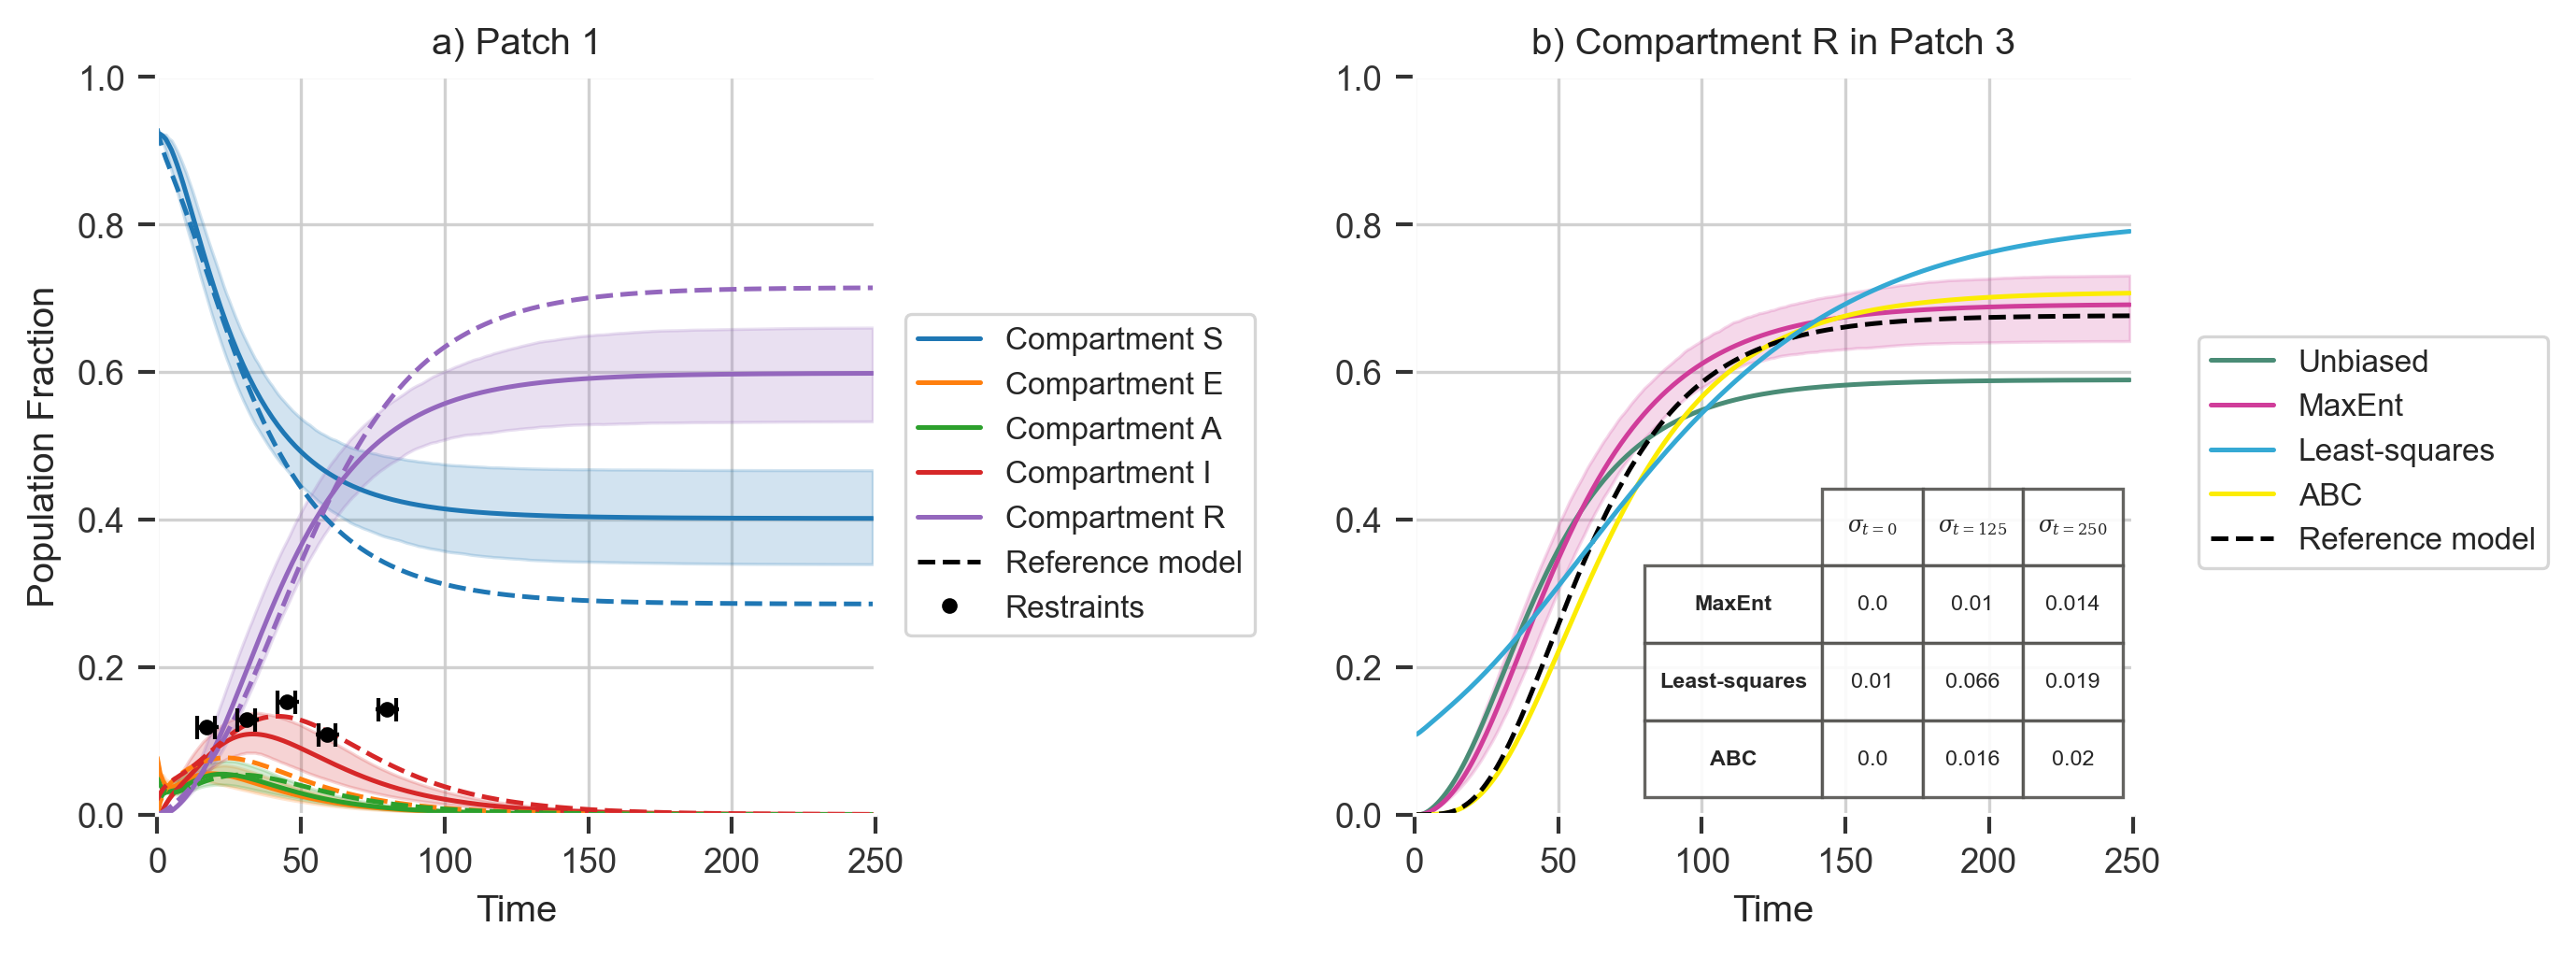

In [543]:
new_stds = np.array(np.round([std_MaxEnt, std_LS, std_abc],3))
abc_sample_trajs = np.load('abc_traj_folds.npy')

def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
abc_trajs = np.load('mean_abc_traj.npy')
sbi_trajs = np.load('mean_sbi_traj.npy')
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [5,5,2.5]})

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_maxentbiased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_maxentbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=me_model.traj_weights), 0, me_model.trajs)
qtrajs_maxentbiased[0, :, :] = np.clip(
            qtrajs_maxentbiased[0, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[2, :, :] = np.clip(
            qtrajs_maxentbiased[2, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[1, :, :] = mtrajs_maxentbiased
print(mtrajs_unbiased.shape)
# for i,y in enumerate(LS_sample_trajs):
#     axs[1].plot(y[:,2,4], color= '#35a9d4', linewidth=0.3)
axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
# axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_trajs[:,2,4], color= '#fcec03')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_maxentbiased[0, :, 2, 4],qtrajs_maxentbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
predicted_label_sbi = 'SNLE'
predicted_line_sbi = plt.Line2D((0,1),(0,0), color='#d47837')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
tb = axs[2].table(cellText=np.round(new_stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=12,
                  edges='BRTL' , bbox=[-0.38,0.19,0.65,0.45], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])
# axs[1].text(0.60,0.28, "5-fold std. '$\sigma $'", size=7, ha="center", 
#          transform=axs[1].transAxes, fontweight='bold', bbox={'facecolor': '#fffa69', 'alpha': 0.5, 'pad': 0})

plt.savefig('Figure_3.svg', transparent=False, dpi = 300)


In [263]:
sbi_times = np.load('sbi_times.npy')
abc_times = np.load('abc_times.npy')
ax,fig = plt.subplots(figsize=(5,3), dpi= 300)

print (sbi_times)

sbi_times = sbi_times/60
abc_times = abc_times/60
number_parameter = range(1,6)
plt.scatter(number_parameter,abc_times, label='ABC', marker ="s",color= '#fcec03')
plt.scatter(number_parameter,sbi_times, label='SBI', color= '#d47837')
plt.setp(plt.gca(), xlim=[0,number_parameter[-1]+0.5],facecolor ='white', xlabel='Number of parameters', ylabel = 'GPU time (min)')
plt.legend(bbox_to_anchor=(0.4,0.8), fontsize=6, frameon=True, fancybox=True, facecolor='white')
print(abc_times)

[ 572.7735908  746.2637107 1152.6794816 1468.5702534 1516.9541984]
[ 9.73750459 12.26920262 12.34665179 11.09788804 12.23159109]


In [249]:
mtrajs_hyperbiased.shape
stds = np.array(np.round([std_MaxEnt, std_LS, std_abc, std_sbi],3))

(250, 3, 5)


(250, 3, 5)

(250, 3, 5)


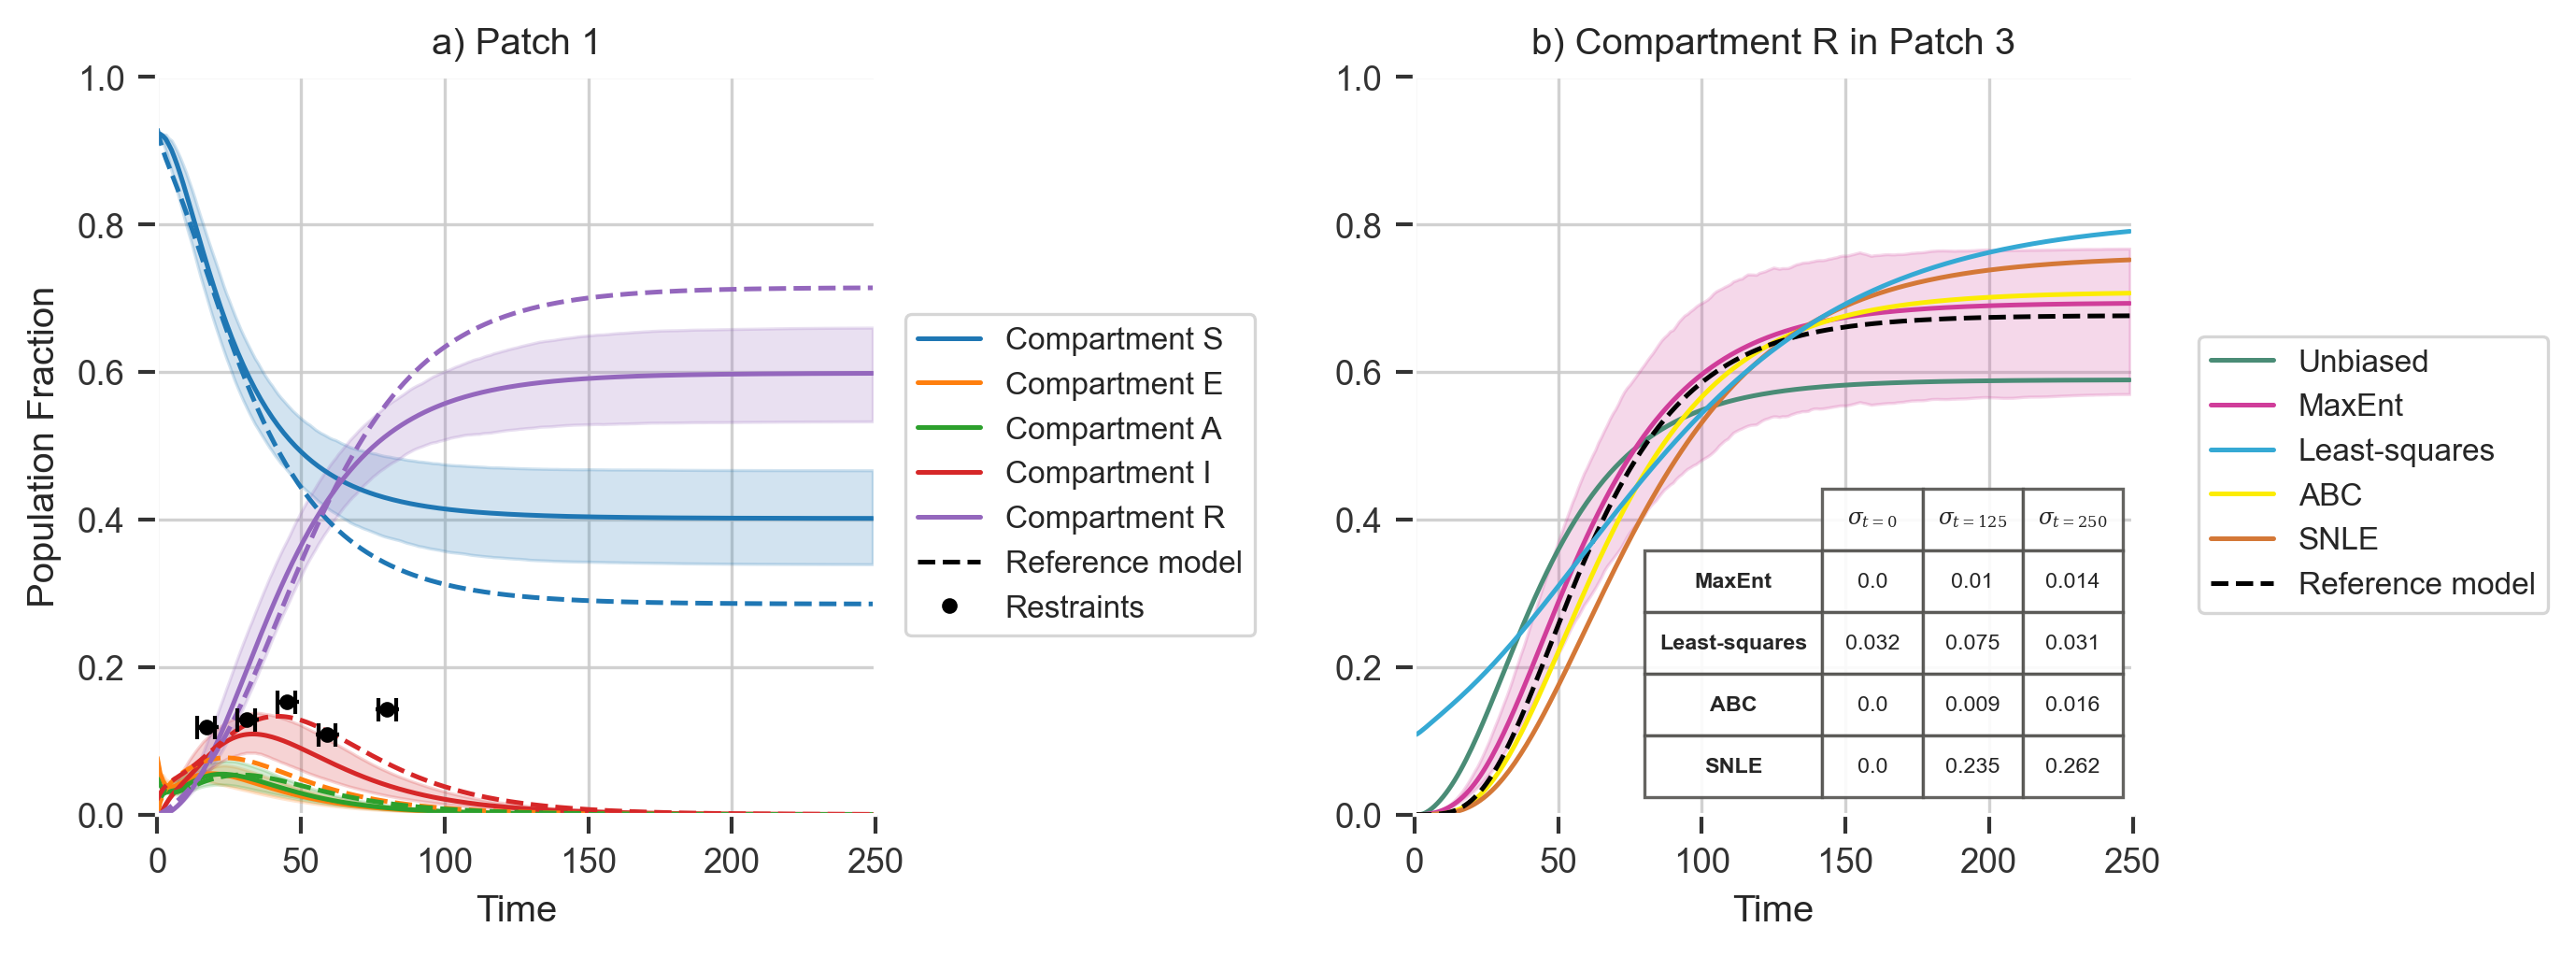

In [540]:

def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
abc_trajs = np.load('mean_abc_traj.npy')
sbi_trajs = np.load('mean_sbi_traj.npy')
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [5,5,2.5]})

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_maxentbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_maxentbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_maxentbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_maxentbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_maxentbiased[1, :, :] = mtrajs_maxentbiased
print(mtrajs_unbiased.shape)
# for i,y in enumerate(LS_sample_trajs):
#     axs[1].plot(y[:,2,4], color= '#35a9d4', linewidth=0.3)
axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
# axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_trajs[:,2,4], color= '#fcec03')
axs[1].plot(x, sbi_trajs[:,2,4], color= '#d47837')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
predicted_label_sbi = 'SNLE'
predicted_line_sbi = plt.Line2D((0,1),(0,0), color='#d47837')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, predicted_line_sbi, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, predicted_label_sbi, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
stds[1,0]=0.032
stds[1,1] = 0.075
stds[1,2] = 0.
stds[0,0]=0.
stds[0,1] = 0.015
stds[0,2] = 0.022
tb = axs[2].table(cellText=np.round(stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC', 'SNLE'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=12,
                  edges='BRTL' , bbox=[-0.38,0.19,0.65,0.45], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])
# axs[1].text(0.60,0.28, "5-fold std. '$\sigma $'", size=7, ha="center", 
#          transform=axs[1].transAxes, fontweight='bold', bbox={'facecolor': '#fffa69', 'alpha': 0.5, 'pad': 0})

plt.savefig('Figure_3_old1.png', transparent=False, dpi = 300)
